# Simulacao leitos - camas limitadas

In [116]:
# Import required modules

import simpy
import random
from random import expovariate, seed
import pandas as pd
import matplotlib.pyplot as plt

In [117]:
300 * 0.8

240.0

In [118]:
240/320

0.75

In [119]:
class g:
    """g holds Global variables. No individual instance is required"""
    
    cases_arriving = 40
    inter_arrival_time = 1/cases_arriving  # Average time (days) between arrivals
    los = 13  # Average length of stay in hospital (days)
    los_uti = 5  # Average length of stay in hospital (days)
    sim_duration = 360  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    
    total_beds = 800
    total_beds_icu = 520
    occupation_rate = 0.4
    icu_occupation_rate = 0.85
    
    icu_rate = 0.4
    icu_after_bed = 0.2
    
    beds = int(total_beds * (1 - occupation_rate))  # beds available
    icu_beds = int(total_beds_icu * (1 - icu_occupation_rate)) # icu beds available

In [120]:
class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Current total icu beds occupied
    6) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        
        self.patients_in_beds = {}
        self.patients_in_icu_beds = {}
        
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_icu_beds = []  # List of icu beds occupied at each audit time
        self.audit_queue = []
        
        self.bed_count = 0  # Current total beds occupied
        self.bed_icu_count = 0
        self.queue_count = 0
        self.admissions = 0  # Admissions to data
        
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """
        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_icu_beds.append(self.bed_icu_count)
        self.audit_queue.append(self.queue_count)
        
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds
        
        self.audit_report['ICU_Occupied_beds'] = self.audit_icu_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)
        
        self.audit_report['ICU_Median_beds'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['ICU_Beds_5_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.05)
        
        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)
        
        self.audit_report['ICU_Beds_95_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.95)

        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)

        return self.audit_report

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        
        
        # Plot occupied icu beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied icu beds')
        
        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')
        
        plt.xlabel('Day')
        plt.ylabel('Occupied icu beds')
        plt.title(
            'Occupied icu beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for beds')
        plt.title('Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return

In [121]:
class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return

    def new_admission(self, interarrival_time, los, los_uti):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1

            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            p = Patient(patient_id=self.hospital.admissions,
                        los=random.expovariate(1 / los),
                        los_uti=random.expovariate(1 / los_uti))
            print('Patient %d arriving %7.2f, admissions count %d' %(p.id,self.env.now,self.hospital.admissions))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            next_admission = random.expovariate(1 / interarrival_time)
            #print('Next patient in %f3.2' %next_admission)
            yield self.env.timeout(next_admission)

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required
        
        # screening - bed or icu bed
        is_icu = 1 if random.uniform(0, 1) > (1-g.icu_rate) else 0
        
        # bed
        if is_icu == 0:
            
            with self.resources.beds.request() as req:
                # Increment queue count
                self.hospital.queue_count += 1
                print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add patient to dictionary of queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p

                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield req

                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add to count of patients in beds and to dictionary of patients in
                # beds
                self.hospital.patients_in_beds[p.id] = p
                self.hospital.bed_count += 1
                print('Patient %d arriving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))

                # Trigger length of stay delay
                yield self.env.timeout(p.los)

                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_count -= 1
                print('Patient %d leaving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                del self.hospital.patients_in_beds[p.id]
            
            # needs icu
            after_is_icu = 1 if random.uniform(0, 1) > (1-g.icu_after_bed) else 0
            
            if after_is_icu == 1:
                
                with self.resources_icu.icu_beds.request() as icu_req:
                    
                    # Increment queue count
                    self.hospital.bed_count += 1
                    print('Patient %d waiting icu %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                
                    # Add patient to dictionary of icu queuing patients. This is not used
                    # further in this model.
                    self.hospital.patients_in_beds[p.id] = p
                
                    # Yield resource request. Sim continues after yield when resources
                    # are vailable (so there is no delay if resources are immediately
                    # available)
                    yield icu_req
                
                    # Resource now available. Remove from queue count and dictionary of
                    # queued objects
                    self.hospital.bed_count -= 1
                    del self.hospital.patients_in_beds[p.id]
                    print('Patient %d leaving bed %7.2f, queue bed %d' %(p.id,self.env.now,self.hospital.bed_count))
                
                    # Add to count of patients in icu beds and to dictionary of patients in
                    # icu beds
                    self.hospital.patients_in_icu_beds[p.id] = p
                    self.hospital.bed_icu_count += 1
                    print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                    # Trigger length of stay delay
                    yield self.env.timeout(p.los_uti)
                
                    # Length of stay complete. Remove patient from counts and
                    # dictionaries
                    self.hospital.bed_icu_count -= 1
                    print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                    del self.hospital.patients_in_icu_beds[p.id]
                    del self.hospital.patients[p.id]
        
        # icu bed
        else:
                    
            with self.resources_icu.icu_beds.request() as icu_req:
                
                # Increment queue count
                self.hospital.queue_count += 1
                print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add patient to dictionary of icu queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p
                
                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield icu_req
                
                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add to count of patients in icu beds and to dictionary of patients in
                # icu beds
                self.hospital.patients_in_icu_beds[p.id] = p
                self.hospital.bed_icu_count += 1
                print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                # Trigger length of stay delay
                yield self.env.timeout(p.los_uti)
                
                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_icu_count -= 1
                print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                del self.hospital.patients_in_icu_beds[p.id]
                del self.hospital.patients[p.id]

        return
    
    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds, icu_beds)
        self.resources = Resources(self.env, g.beds)
        self.resources_icu = Resources_ICU(self.env, g.icu_beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los, g.los_uti))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        #self.hospital.chart()

        return

In [122]:
class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los, los_uti):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los
        self.los_uti = los_uti

        return

In [123]:
class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return

In [124]:
class Resources_ICU:
    """
    Holds icu beds resources
    """

    def __init__(self, env, number_of_icu_beds):
        """        Constructor method to initialise icu beds resource)"""
        self.icu_beds = simpy.Resource(env, capacity=number_of_icu_beds)

        return

In [125]:
def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return

In [126]:
## Code entry point. Calls main method.
#if __name__ == '__main__':
#    main()

In [127]:
model = Model()

In [128]:
%%time
seed(98989)
model.run()

Patient 1 arriving    0.00, admissions count 1
Patient 1 arriving queue    0.00, queue count 1
Patient 1 leaving queue    0.00, queue count 0
Patient 1 arriving bed    0.00, bed count 1
Patient 2 arriving    0.01, admissions count 2
Patient 2 arriving queue    0.01, queue count 1
Patient 2 leaving queue    0.01, queue count 0
Patient 2 arriving icu bed    0.01, icu bed count 1
Patient 3 arriving    0.02, admissions count 3
Patient 3 arriving queue    0.02, queue count 1
Patient 3 leaving queue    0.02, queue count 0
Patient 3 arriving bed    0.02, bed count 2
Patient 4 arriving    0.03, admissions count 4
Patient 4 arriving queue    0.03, queue count 1
Patient 4 leaving queue    0.03, queue count 0
Patient 4 arriving icu bed    0.03, icu bed count 2
Patient 5 arriving    0.04, admissions count 5
Patient 5 arriving queue    0.04, queue count 1
Patient 5 leaving queue    0.04, queue count 0
Patient 5 arriving bed    0.04, bed count 3
Patient 6 arriving    0.05, admissions count 6
Patient

Patient 261 arriving    6.77, admissions count 261
Patient 261 arriving queue    6.77, queue count 1
Patient 261 leaving queue    6.77, queue count 0
Patient 261 arriving icu bed    6.77, icu bed count 51
Patient 241 leaving bed    6.77, bed count 126
Patient 262 arriving    6.78, admissions count 262
Patient 262 arriving queue    6.78, queue count 1
Patient 262 leaving queue    6.78, queue count 0
Patient 262 arriving bed    6.78, bed count 127
Patient 263 arriving    6.82, admissions count 263
Patient 263 arriving queue    6.82, queue count 1
Patient 263 leaving queue    6.82, queue count 0
Patient 263 arriving bed    6.82, bed count 128
Patient 264 arriving    6.85, admissions count 264
Patient 264 arriving queue    6.85, queue count 1
Patient 264 leaving queue    6.85, queue count 0
Patient 264 arriving bed    6.85, bed count 129
Patient 138 leaving icu bed    6.87, icu bed count 50
Patient 265 arriving    6.89, admissions count 265
Patient 265 arriving queue    6.89, queue count 1

Patient 412 arriving bed   10.33, bed count 177
Patient 322 leaving icu bed   10.33, icu bed count 77
Patient 403 leaving queue   10.33, queue count 3
Patient 403 arriving icu bed   10.33, icu bed count 78
Patient 150 leaving bed   10.34, bed count 176
Patient 150 waiting icu   10.34, bed count 177
Patient 352 leaving bed   10.37, bed count 176
Patient 413 arriving   10.38, admissions count 413
Patient 413 arriving queue   10.38, queue count 4
Patient 325 leaving icu bed   10.41, icu bed count 77
Patient 404 leaving queue   10.41, queue count 3
Patient 404 arriving icu bed   10.41, icu bed count 78
Patient 414 arriving   10.42, admissions count 414
Patient 414 arriving queue   10.42, queue count 4
Patient 415 arriving   10.42, admissions count 415
Patient 415 arriving queue   10.42, queue count 5
Patient 415 leaving queue   10.42, queue count 4
Patient 415 arriving bed   10.42, bed count 177
Patient 416 arriving   10.42, admissions count 416
Patient 416 arriving queue   10.42, queue co

Patient 623 arriving   14.88, admissions count 623
Patient 623 arriving queue   14.88, queue count 24
Patient 623 leaving queue   14.88, queue count 23
Patient 623 arriving bed   14.88, bed count 224
Patient 624 arriving   14.88, admissions count 624
Patient 624 arriving queue   14.88, queue count 24
Patient 624 leaving queue   14.88, queue count 23
Patient 624 arriving bed   14.88, bed count 225
Patient 461 leaving bed   14.91, bed count 224
Patient 625 arriving   14.91, admissions count 625
Patient 625 arriving queue   14.91, queue count 24
Patient 626 arriving   14.92, admissions count 626
Patient 626 arriving queue   14.92, queue count 25
Patient 626 leaving queue   14.92, queue count 24
Patient 626 arriving bed   14.92, bed count 225
Patient 554 leaving icu bed   14.93, icu bed count 77
Patient 576 leaving queue   14.93, queue count 23
Patient 576 arriving icu bed   14.93, icu bed count 78
Patient 627 arriving   14.98, admissions count 627
Patient 627 arriving queue   14.98, queue

Patient 828 arriving queue   19.56, queue count 35
Patient 829 arriving   19.57, admissions count 829
Patient 829 arriving queue   19.57, queue count 36
Patient 829 leaving queue   19.57, queue count 35
Patient 829 arriving bed   19.57, bed count 278
Patient 830 arriving   19.58, admissions count 830
Patient 830 arriving queue   19.58, queue count 36
Patient 823 leaving bed   19.58, bed count 277
Patient 831 arriving   19.58, admissions count 831
Patient 831 arriving queue   19.58, queue count 37
Patient 831 leaving queue   19.58, queue count 36
Patient 831 arriving bed   19.58, bed count 278
Patient 581 leaving icu bed   19.59, icu bed count 77
Patient 743 leaving queue   19.59, queue count 35
Patient 743 arriving icu bed   19.59, icu bed count 78
Patient 832 arriving   19.59, admissions count 832
Patient 832 arriving queue   19.59, queue count 36
Patient 832 leaving queue   19.59, queue count 35
Patient 832 arriving bed   19.59, bed count 279
Patient 742 leaving bed   19.59, bed coun

Patient 962 leaving bed   24.70, bed count 297
Patient 840 leaving icu bed   24.71, icu bed count 77
Patient 890 leaving queue   24.71, queue count 58
Patient 890 arriving icu bed   24.71, icu bed count 78
Patient 1035 arriving   24.72, admissions count 1035
Patient 1035 arriving queue   24.72, queue count 59
Patient 1035 leaving queue   24.72, queue count 58
Patient 1035 arriving bed   24.72, bed count 298
Patient 1036 arriving   24.72, admissions count 1036
Patient 1036 arriving queue   24.72, queue count 59
Patient 1036 leaving queue   24.72, queue count 58
Patient 1036 arriving bed   24.72, bed count 299
Patient 468 leaving icu bed   24.76, icu bed count 77
Patient 891 leaving queue   24.76, queue count 57
Patient 891 arriving icu bed   24.76, icu bed count 78
Patient 1037 arriving   24.78, admissions count 1037
Patient 1037 arriving queue   24.78, queue count 58
Patient 1037 leaving queue   24.78, queue count 57
Patient 1037 arriving bed   24.78, bed count 300
Patient 1038 arrivin

Patient 601 leaving icu bed   29.40, icu bed count 77
Patient 1050 leaving queue   29.40, queue count 74
Patient 1050 arriving icu bed   29.40, icu bed count 78
Patient 1152 leaving bed   29.41, bed count 310
Patient 1152 waiting icu   29.41, bed count 311
Patient 1237 arriving   29.41, admissions count 1237
Patient 1237 arriving queue   29.41, queue count 75
Patient 1237 leaving queue   29.41, queue count 74
Patient 1237 arriving bed   29.41, bed count 312
Patient 758 leaving icu bed   29.43, icu bed count 77
Patient 334 leaving bed   29.43, queue bed 311
Patient 334 arriving icu bed   29.43, icu bed count 78
Patient 1043 leaving bed   29.44, bed count 310
Patient 1043 waiting icu   29.44, bed count 311
Patient 1238 arriving   29.44, admissions count 1238
Patient 1238 arriving queue   29.44, queue count 75
Patient 1239 arriving   29.45, admissions count 1239
Patient 1239 arriving queue   29.45, queue count 76
Patient 1239 leaving queue   29.45, queue count 75
Patient 1239 arriving bed

Patient 1421 arriving queue   34.63, queue count 70
Patient 1421 leaving queue   34.63, queue count 69
Patient 1421 arriving bed   34.63, bed count 335
Patient 1411 leaving bed   34.64, bed count 334
Patient 1411 waiting icu   34.64, bed count 335
Patient 1422 arriving   34.66, admissions count 1422
Patient 1422 arriving queue   34.66, queue count 70
Patient 1422 leaving queue   34.66, queue count 69
Patient 1422 arriving bed   34.66, bed count 336
Patient 1086 leaving icu bed   34.66, icu bed count 77
Patient 1209 leaving queue   34.66, queue count 68
Patient 1209 arriving icu bed   34.66, icu bed count 78
Patient 1423 arriving   34.68, admissions count 1423
Patient 1423 arriving queue   34.68, queue count 69
Patient 1424 arriving   34.68, admissions count 1424
Patient 1424 arriving queue   34.68, queue count 70
Patient 1424 leaving queue   34.68, queue count 69
Patient 1424 arriving bed   34.68, bed count 337
Patient 1367 leaving bed   34.69, bed count 336
Patient 1367 waiting icu   

Patient 1627 leaving queue   39.69, queue count 105
Patient 1627 arriving bed   39.69, bed count 341
Patient 1628 arriving   39.69, admissions count 1628
Patient 1628 arriving queue   39.69, queue count 106
Patient 1628 leaving queue   39.69, queue count 105
Patient 1628 arriving bed   39.69, bed count 342
Patient 1325 leaving icu bed   39.70, icu bed count 77
Patient 1344 leaving queue   39.70, queue count 104
Patient 1344 arriving icu bed   39.70, icu bed count 78
Patient 1629 arriving   39.70, admissions count 1629
Patient 1629 arriving queue   39.70, queue count 105
Patient 1629 leaving queue   39.70, queue count 104
Patient 1629 arriving bed   39.70, bed count 343
Patient 1313 leaving icu bed   39.72, icu bed count 77
Patient 1347 leaving queue   39.72, queue count 103
Patient 1347 arriving icu bed   39.72, icu bed count 78
Patient 1630 arriving   39.73, admissions count 1630
Patient 1630 arriving queue   39.73, queue count 104
Patient 1630 leaving queue   39.73, queue count 103
P

Patient 1816 arriving   44.28, admissions count 1816
Patient 1816 arriving queue   44.28, queue count 111
Patient 1502 leaving icu bed   44.28, icu bed count 77
Patient 1521 leaving queue   44.28, queue count 110
Patient 1521 arriving icu bed   44.28, icu bed count 78
Patient 1817 arriving   44.29, admissions count 1817
Patient 1817 arriving queue   44.29, queue count 111
Patient 1487 leaving icu bed   44.29, icu bed count 77
Patient 1525 leaving queue   44.29, queue count 110
Patient 1525 arriving icu bed   44.29, icu bed count 78
Patient 1326 leaving icu bed   44.30, icu bed count 77
Patient 1526 leaving queue   44.30, queue count 109
Patient 1526 arriving icu bed   44.30, icu bed count 78
Patient 1800 leaving bed   44.30, bed count 359
Patient 1382 leaving icu bed   44.31, icu bed count 77
Patient 1420 leaving bed   44.31, queue bed 358
Patient 1420 arriving icu bed   44.31, icu bed count 78
Patient 1337 leaving bed   44.31, bed count 357
Patient 1337 waiting icu   44.31, bed count 

Patient 2014 arriving queue   49.02, queue count 131
Patient 2014 leaving queue   49.02, queue count 130
Patient 2014 arriving bed   49.02, bed count 355
Patient 858 leaving bed   49.04, bed count 354
Patient 2015 arriving   49.06, admissions count 2015
Patient 2015 arriving queue   49.06, queue count 131
Patient 1708 leaving bed   49.07, bed count 353
Patient 1655 leaving bed   49.07, bed count 352
Patient 1248 leaving icu bed   49.13, icu bed count 77
Patient 1684 leaving queue   49.13, queue count 130
Patient 1684 arriving icu bed   49.13, icu bed count 78
Patient 1200 leaving icu bed   49.14, icu bed count 77
Patient 1693 leaving queue   49.14, queue count 129
Patient 1693 arriving icu bed   49.14, icu bed count 78
Patient 1839 leaving bed   49.14, bed count 351
Patient 1839 waiting icu   49.14, bed count 352
Patient 2016 arriving   49.16, admissions count 2016
Patient 2016 arriving queue   49.16, queue count 130
Patient 2017 arriving   49.17, admissions count 2017
Patient 2017 arr

Patient 2209 arriving   53.52, admissions count 2209
Patient 2209 arriving queue   53.52, queue count 154
Patient 2209 leaving queue   53.52, queue count 153
Patient 2209 arriving bed   53.52, bed count 354
Patient 2210 arriving   53.53, admissions count 2210
Patient 2210 arriving queue   53.53, queue count 154
Patient 2210 leaving queue   53.53, queue count 153
Patient 2210 arriving bed   53.53, bed count 355
Patient 2211 arriving   53.55, admissions count 2211
Patient 2211 arriving queue   53.55, queue count 154
Patient 2211 leaving queue   53.55, queue count 153
Patient 2211 arriving bed   53.55, bed count 356
Patient 2212 arriving   53.59, admissions count 2212
Patient 2212 arriving queue   53.59, queue count 154
Patient 2213 arriving   53.59, admissions count 2213
Patient 2213 arriving queue   53.59, queue count 155
Patient 2213 leaving queue   53.59, queue count 154
Patient 2213 arriving bed   53.59, bed count 357
Patient 1791 leaving icu bed   53.64, icu bed count 77
Patient 183

Patient 2414 arriving bed   58.20, bed count 364
Patient 1927 leaving bed   58.20, bed count 363
Patient 2415 arriving   58.21, admissions count 2415
Patient 2415 arriving queue   58.21, queue count 181
Patient 2415 leaving queue   58.21, queue count 180
Patient 2415 arriving bed   58.21, bed count 364
Patient 2416 arriving   58.21, admissions count 2416
Patient 2416 arriving queue   58.21, queue count 181
Patient 2416 leaving queue   58.21, queue count 180
Patient 2416 arriving bed   58.21, bed count 365
Patient 2417 arriving   58.22, admissions count 2417
Patient 2417 arriving queue   58.22, queue count 181
Patient 2417 leaving queue   58.22, queue count 180
Patient 2417 arriving bed   58.22, bed count 366
Patient 1913 leaving bed   58.26, bed count 365
Patient 1954 leaving icu bed   58.26, icu bed count 77
Patient 1965 leaving queue   58.26, queue count 179
Patient 1965 arriving icu bed   58.26, icu bed count 78
Patient 2418 arriving   58.28, admissions count 2418
Patient 2418 arriv

Patient 2605 arriving queue   62.78, queue count 178
Patient 2559 leaving bed   62.80, bed count 384
Patient 2606 arriving   62.81, admissions count 2606
Patient 2606 arriving queue   62.81, queue count 179
Patient 2505 leaving bed   62.82, bed count 383
Patient 1930 leaving icu bed   62.84, icu bed count 77
Patient 2131 leaving queue   62.84, queue count 178
Patient 2131 arriving icu bed   62.84, icu bed count 78
Patient 2081 leaving bed   62.85, bed count 382
Patient 2607 arriving   62.86, admissions count 2607
Patient 2607 arriving queue   62.86, queue count 179
Patient 2608 arriving   62.86, admissions count 2608
Patient 2608 arriving queue   62.86, queue count 180
Patient 2609 arriving   62.87, admissions count 2609
Patient 2609 arriving queue   62.87, queue count 181
Patient 2609 leaving queue   62.87, queue count 180
Patient 2609 arriving bed   62.87, bed count 383
Patient 2058 leaving icu bed   62.89, icu bed count 77
Patient 2134 leaving queue   62.89, queue count 179
Patient 

Patient 2800 arriving   67.95, admissions count 2800
Patient 2800 arriving queue   67.95, queue count 209
Patient 2800 leaving queue   67.95, queue count 208
Patient 2800 arriving bed   67.95, bed count 348
Patient 2801 arriving   67.99, admissions count 2801
Patient 2801 arriving queue   67.99, queue count 209
Patient 1482 leaving icu bed   68.00, icu bed count 77
Patient 2279 leaving queue   68.00, queue count 208
Patient 2279 arriving icu bed   68.00, icu bed count 78
Patient 2802 arriving   68.00, admissions count 2802
Patient 2802 arriving queue   68.00, queue count 209
Patient 2277 leaving icu bed   68.00, icu bed count 77
Patient 1765 leaving bed   68.00, queue bed 347
Patient 1765 arriving icu bed   68.00, icu bed count 78
Patient 2803 arriving   68.02, admissions count 2803
Patient 2803 arriving queue   68.02, queue count 210
Patient 2804 arriving   68.04, admissions count 2804
Patient 2804 arriving queue   68.04, queue count 211
Patient 2269 leaving icu bed   68.06, icu bed c

Patient 2419 arriving icu bed   72.63, icu bed count 78
Patient 2604 leaving bed   72.64, bed count 368
Patient 2996 arriving   72.64, admissions count 2996
Patient 2996 arriving queue   72.64, queue count 222
Patient 2650 leaving bed   72.67, bed count 367
Patient 2997 arriving   72.67, admissions count 2997
Patient 2997 arriving queue   72.67, queue count 223
Patient 2997 leaving queue   72.67, queue count 222
Patient 2997 arriving bed   72.67, bed count 368
Patient 2088 leaving icu bed   72.69, icu bed count 77
Patient 2423 leaving queue   72.69, queue count 221
Patient 2423 arriving icu bed   72.69, icu bed count 78
Patient 2335 leaving icu bed   72.70, icu bed count 77
Patient 2257 leaving bed   72.70, queue bed 367
Patient 2257 arriving icu bed   72.70, icu bed count 78
Patient 2323 leaving icu bed   72.70, icu bed count 77
Patient 2427 leaving queue   72.70, queue count 220
Patient 2427 arriving icu bed   72.70, icu bed count 78
Patient 2192 leaving icu bed   72.72, icu bed coun

Patient 3189 arriving queue   77.53, queue count 230
Patient 3190 arriving   77.53, admissions count 3190
Patient 3190 arriving queue   77.53, queue count 231
Patient 2357 leaving bed   77.66, bed count 390
Patient 3108 leaving bed   77.68, bed count 389
Patient 2847 leaving bed   77.69, bed count 388
Patient 3191 arriving   77.70, admissions count 3191
Patient 3191 arriving queue   77.70, queue count 232
Patient 3191 leaving queue   77.70, queue count 231
Patient 3191 arriving bed   77.70, bed count 389
Patient 3192 arriving   77.72, admissions count 3192
Patient 3192 arriving queue   77.72, queue count 232
Patient 2397 leaving icu bed   77.75, icu bed count 77
Patient 2610 leaving queue   77.75, queue count 231
Patient 2610 arriving icu bed   77.75, icu bed count 78
Patient 3193 arriving   77.79, admissions count 3193
Patient 3193 arriving queue   77.79, queue count 232
Patient 3193 leaving queue   77.79, queue count 231
Patient 3193 arriving bed   77.79, bed count 390
Patient 3194 a

Patient 3400 arriving queue   82.69, queue count 267
Patient 2042 leaving bed   82.69, bed count 390
Patient 3401 arriving   82.70, admissions count 3401
Patient 3401 arriving queue   82.70, queue count 268
Patient 3401 leaving queue   82.70, queue count 267
Patient 3401 arriving bed   82.70, bed count 391
Patient 3402 arriving   82.71, admissions count 3402
Patient 3402 arriving queue   82.71, queue count 268
Patient 3402 leaving queue   82.71, queue count 267
Patient 3402 arriving bed   82.71, bed count 392
Patient 3297 leaving bed   82.71, bed count 391
Patient 3403 arriving   82.72, admissions count 3403
Patient 3403 arriving queue   82.72, queue count 268
Patient 3403 leaving queue   82.72, queue count 267
Patient 3403 arriving bed   82.72, bed count 392
Patient 2656 leaving bed   82.74, bed count 391
Patient 2470 leaving icu bed   82.74, icu bed count 77
Patient 2746 leaving queue   82.74, queue count 266
Patient 2746 arriving icu bed   82.74, icu bed count 78
Patient 3404 arrivi

Patient 3599 arriving   87.16, admissions count 3599
Patient 3599 arriving queue   87.16, queue count 287
Patient 3600 arriving   87.18, admissions count 3600
Patient 3600 arriving queue   87.18, queue count 288
Patient 3600 leaving queue   87.18, queue count 287
Patient 3600 arriving bed   87.18, bed count 403
Patient 2683 leaving icu bed   87.19, icu bed count 77
Patient 2886 leaving queue   87.19, queue count 286
Patient 2886 arriving icu bed   87.19, icu bed count 78
Patient 3601 arriving   87.20, admissions count 3601
Patient 3601 arriving queue   87.20, queue count 287
Patient 3602 arriving   87.21, admissions count 3602
Patient 3602 arriving queue   87.21, queue count 288
Patient 2539 leaving icu bed   87.22, icu bed count 77
Patient 2887 leaving queue   87.22, queue count 287
Patient 2887 arriving icu bed   87.22, icu bed count 78
Patient 3603 arriving   87.22, admissions count 3603
Patient 3603 arriving queue   87.22, queue count 288
Patient 3604 arriving   87.23, admissions c

Patient 3799 arriving   91.89, admissions count 3799
Patient 3799 arriving queue   91.89, queue count 308
Patient 3799 leaving queue   91.89, queue count 307
Patient 3799 arriving bed   91.89, bed count 410
Patient 2900 leaving icu bed   91.89, icu bed count 77
Patient 2626 leaving bed   91.89, queue bed 409
Patient 2626 arriving icu bed   91.89, icu bed count 78
Patient 3519 leaving bed   91.90, bed count 408
Patient 3523 leaving bed   91.91, bed count 407
Patient 3523 waiting icu   91.91, bed count 408
Patient 3012 leaving icu bed   91.95, icu bed count 77
Patient 3033 leaving queue   91.95, queue count 306
Patient 3033 arriving icu bed   91.95, icu bed count 78
Patient 3298 leaving bed   91.96, bed count 407
Patient 3800 arriving   91.96, admissions count 3800
Patient 3800 arriving queue   91.96, queue count 307
Patient 3473 leaving bed   91.99, bed count 406
Patient 3473 waiting icu   91.99, bed count 407
Patient 3801 arriving   92.00, admissions count 3801
Patient 3801 arriving qu

Patient 3993 arriving   96.58, admissions count 3993
Patient 3993 arriving queue   96.58, queue count 331
Patient 3993 leaving queue   96.58, queue count 330
Patient 3993 arriving bed   96.58, bed count 412
Patient 3994 arriving   96.59, admissions count 3994
Patient 3994 arriving queue   96.59, queue count 331
Patient 3994 leaving queue   96.59, queue count 330
Patient 3994 arriving bed   96.59, bed count 413
Patient 3995 arriving   96.60, admissions count 3995
Patient 3995 arriving queue   96.60, queue count 331
Patient 2864 leaving bed   96.62, bed count 412
Patient 3852 leaving bed   96.63, bed count 411
Patient 2680 leaving icu bed   96.63, icu bed count 77
Patient 2823 leaving bed   96.63, queue bed 410
Patient 2823 arriving icu bed   96.63, icu bed count 78
Patient 2907 leaving icu bed   96.64, icu bed count 77
Patient 3174 leaving queue   96.64, queue count 330
Patient 3174 arriving icu bed   96.64, icu bed count 78
Patient 3921 leaving bed   96.65, bed count 409
Patient 3921 w

Patient 4177 leaving queue  101.59, queue count 328
Patient 4177 arriving bed  101.59, bed count 424
Patient 3906 leaving bed  101.59, bed count 423
Patient 4178 arriving  101.60, admissions count 4178
Patient 4178 arriving queue  101.60, queue count 329
Patient 4058 leaving bed  101.64, bed count 422
Patient 4179 arriving  101.67, admissions count 4179
Patient 4179 arriving queue  101.67, queue count 330
Patient 4179 leaving queue  101.67, queue count 329
Patient 4179 arriving bed  101.67, bed count 423
Patient 4180 arriving  101.71, admissions count 4180
Patient 4180 arriving queue  101.71, queue count 330
Patient 4180 leaving queue  101.71, queue count 329
Patient 4180 arriving bed  101.71, bed count 424
Patient 4181 arriving  101.73, admissions count 4181
Patient 4181 arriving queue  101.73, queue count 330
Patient 4024 leaving bed  101.75, bed count 423
Patient 4024 waiting icu  101.75, bed count 424
Patient 3100 leaving bed  101.76, bed count 423
Patient 3454 leaving bed  101.76,

Patient 4224 leaving bed  106.34, bed count 433
Patient 3943 leaving bed  106.35, bed count 432
Patient 4360 arriving  106.35, admissions count 4360
Patient 4360 arriving queue  106.35, queue count 328
Patient 3937 leaving bed  106.36, bed count 431
Patient 4361 arriving  106.36, admissions count 4361
Patient 4361 arriving queue  106.36, queue count 329
Patient 4361 leaving queue  106.36, queue count 328
Patient 4361 arriving bed  106.36, bed count 432
Patient 4362 arriving  106.36, admissions count 4362
Patient 4362 arriving queue  106.36, queue count 329
Patient 4362 leaving queue  106.36, queue count 328
Patient 4362 arriving bed  106.36, bed count 433
Patient 3089 leaving bed  106.38, bed count 432
Patient 3287 leaving icu bed  106.39, icu bed count 77
Patient 3529 leaving queue  106.39, queue count 327
Patient 3529 arriving icu bed  106.39, icu bed count 78
Patient 4363 arriving  106.40, admissions count 4363
Patient 4363 arriving queue  106.40, queue count 328
Patient 4363 leavin

Patient 4616 arriving queue  112.35, queue count 358
Patient 3778 leaving bed  112.36, bed count 443
Patient 3778 waiting icu  112.36, bed count 444
Patient 4588 leaving bed  112.37, bed count 443
Patient 3613 leaving bed  112.37, bed count 442
Patient 3414 leaving icu bed  112.39, icu bed count 77
Patient 3707 leaving queue  112.39, queue count 357
Patient 3707 arriving icu bed  112.39, icu bed count 78
Patient 4171 leaving bed  112.39, bed count 441
Patient 4603 leaving bed  112.39, bed count 440
Patient 4603 waiting icu  112.39, bed count 441
Patient 3722 leaving bed  112.41, bed count 440
Patient 4617 arriving  112.43, admissions count 4617
Patient 4617 arriving queue  112.43, queue count 358
Patient 4617 leaving queue  112.43, queue count 357
Patient 4617 arriving bed  112.43, bed count 441
Patient 3445 leaving bed  112.44, bed count 440
Patient 4618 arriving  112.45, admissions count 4618
Patient 4618 arriving queue  112.45, queue count 358
Patient 4619 arriving  112.46, admissio

Patient 4802 leaving queue  117.12, queue count 367
Patient 4802 arriving bed  117.12, bed count 467
Patient 4553 leaving bed  117.12, bed count 466
Patient 4553 waiting icu  117.12, bed count 467
Patient 4803 arriving  117.15, admissions count 4803
Patient 4803 arriving queue  117.15, queue count 368
Patient 4803 leaving queue  117.15, queue count 367
Patient 4803 arriving bed  117.15, bed count 468
Patient 4804 arriving  117.15, admissions count 4804
Patient 4804 arriving queue  117.15, queue count 368
Patient 4804 leaving queue  117.15, queue count 367
Patient 4804 arriving bed  117.15, bed count 469
Patient 4755 leaving bed  117.15, bed count 468
Patient 2616 leaving icu bed  117.16, icu bed count 77
Patient 3864 leaving queue  117.16, queue count 366
Patient 3864 arriving icu bed  117.16, icu bed count 78
Patient 4122 leaving bed  117.16, bed count 467
Patient 4513 leaving bed  117.17, bed count 466
Patient 3822 leaving icu bed  117.21, icu bed count 77
Patient 3869 leaving queue 

Patient 2155 leaving icu bed  120.71, icu bed count 77
Patient 3952 leaving queue  120.71, queue count 387
Patient 3952 arriving icu bed  120.71, icu bed count 78
Patient 4967 arriving  120.76, admissions count 4967
Patient 4967 arriving queue  120.76, queue count 388
Patient 4968 arriving  120.76, admissions count 4968
Patient 4968 arriving queue  120.76, queue count 389
Patient 4968 leaving queue  120.76, queue count 388
Patient 4968 arriving bed  120.76, bed count 479
Patient 4969 arriving  120.77, admissions count 4969
Patient 4969 arriving queue  120.77, queue count 389
Patient 4413 leaving bed  120.80, bed count 478
Patient 4970 arriving  120.83, admissions count 4970
Patient 4970 arriving queue  120.83, queue count 390
Patient 4970 leaving queue  120.83, queue count 389
Patient 4970 arriving bed  120.83, bed count 479
Patient 3867 leaving bed  120.83, bed count 478
Patient 3605 leaving icu bed  120.91, icu bed count 77
Patient 3783 leaving bed  120.91, queue bed 477
Patient 3783

Patient 5150 leaving queue  125.32, queue count 405
Patient 5150 arriving bed  125.32, bed count 469
Patient 4566 leaving bed  125.34, bed count 468
Patient 4566 waiting icu  125.34, bed count 469
Patient 5151 arriving  125.34, admissions count 5151
Patient 5151 arriving queue  125.34, queue count 406
Patient 5078 leaving bed  125.35, bed count 468
Patient 5078 waiting icu  125.35, bed count 469
Patient 5152 arriving  125.36, admissions count 5152
Patient 5152 arriving queue  125.36, queue count 407
Patient 5152 leaving queue  125.36, queue count 406
Patient 5152 arriving bed  125.36, bed count 470
Patient 5153 arriving  125.39, admissions count 5153
Patient 5153 arriving queue  125.39, queue count 407
Patient 5153 leaving queue  125.39, queue count 406
Patient 5153 arriving bed  125.39, bed count 471
Patient 5154 arriving  125.40, admissions count 5154
Patient 5154 arriving queue  125.40, queue count 407
Patient 5154 leaving queue  125.40, queue count 406
Patient 5154 arriving bed  12

Patient 5350 arriving queue  130.36, queue count 448
Patient 5094 leaving bed  130.40, bed count 450
Patient 5351 arriving  130.41, admissions count 5351
Patient 5351 arriving queue  130.41, queue count 449
Patient 5090 leaving bed  130.43, bed count 449
Patient 5352 arriving  130.45, admissions count 5352
Patient 5352 arriving queue  130.45, queue count 450
Patient 5353 arriving  130.45, admissions count 5353
Patient 5353 arriving queue  130.45, queue count 451
Patient 5353 leaving queue  130.45, queue count 450
Patient 5353 arriving bed  130.45, bed count 450
Patient 4277 leaving bed  130.46, bed count 449
Patient 5354 arriving  130.46, admissions count 5354
Patient 5354 arriving queue  130.46, queue count 451
Patient 5354 leaving queue  130.46, queue count 450
Patient 5354 arriving bed  130.46, bed count 450
Patient 5355 arriving  130.49, admissions count 5355
Patient 5355 arriving queue  130.49, queue count 451
Patient 5355 leaving queue  130.49, queue count 450
Patient 5355 arrivi

Patient 4394 leaving queue  135.31, queue count 461
Patient 4394 arriving icu bed  135.31, icu bed count 78
Patient 5542 arriving  135.33, admissions count 5542
Patient 5542 arriving queue  135.33, queue count 462
Patient 5542 leaving queue  135.33, queue count 461
Patient 5542 arriving bed  135.33, bed count 438
Patient 5379 leaving bed  135.33, bed count 437
Patient 4339 leaving icu bed  135.34, icu bed count 77
Patient 3868 leaving bed  135.34, queue bed 436
Patient 3868 arriving icu bed  135.34, icu bed count 78
Patient 5543 arriving  135.36, admissions count 5543
Patient 5543 arriving queue  135.36, queue count 462
Patient 5544 arriving  135.37, admissions count 5544
Patient 5544 arriving queue  135.37, queue count 463
Patient 4383 leaving icu bed  135.41, icu bed count 77
Patient 4399 leaving queue  135.41, queue count 462
Patient 4399 arriving icu bed  135.41, icu bed count 78
Patient 5545 arriving  135.45, admissions count 5545
Patient 5545 arriving queue  135.45, queue count 4

Patient 5360 leaving bed  140.22, bed count 433
Patient 5734 arriving  140.23, admissions count 5734
Patient 5734 arriving queue  140.23, queue count 477
Patient 5734 leaving queue  140.23, queue count 476
Patient 5734 arriving bed  140.23, bed count 434
Patient 5735 arriving  140.24, admissions count 5735
Patient 5735 arriving queue  140.24, queue count 477
Patient 5359 leaving bed  140.25, bed count 433
Patient 5359 waiting icu  140.25, bed count 434
Patient 5736 arriving  140.25, admissions count 5736
Patient 5736 arriving queue  140.25, queue count 478
Patient 5737 arriving  140.28, admissions count 5737
Patient 5737 arriving queue  140.28, queue count 479
Patient 5737 leaving queue  140.28, queue count 478
Patient 5737 arriving bed  140.28, bed count 435
Patient 5344 leaving bed  140.28, bed count 434
Patient 4170 leaving icu bed  140.29, icu bed count 77
Patient 4568 leaving queue  140.29, queue count 477
Patient 4568 arriving icu bed  140.29, icu bed count 78
Patient 5738 arrivi

Patient 5935 leaving queue  145.27, queue count 506
Patient 5935 arriving bed  145.27, bed count 433
Patient 5385 leaving bed  145.29, bed count 432
Patient 5385 waiting icu  145.29, bed count 433
Patient 4551 leaving icu bed  145.29, icu bed count 77
Patient 4711 leaving queue  145.29, queue count 505
Patient 4711 arriving icu bed  145.29, icu bed count 78
Patient 5936 arriving  145.30, admissions count 5936
Patient 5936 arriving queue  145.30, queue count 506
Patient 5438 leaving bed  145.31, bed count 432
Patient 4700 leaving icu bed  145.32, icu bed count 77
Patient 4719 leaving queue  145.32, queue count 505
Patient 4719 arriving icu bed  145.32, icu bed count 78
Patient 5762 leaving bed  145.35, bed count 431
Patient 5937 arriving  145.37, admissions count 5937
Patient 5937 arriving queue  145.37, queue count 506
Patient 5937 leaving queue  145.37, queue count 505
Patient 5937 arriving bed  145.37, bed count 432
Patient 5938 arriving  145.40, admissions count 5938
Patient 5938 ar

Patient 6127 arriving queue  150.32, queue count 522
Patient 5667 leaving bed  150.33, bed count 435
Patient 3662 leaving icu bed  150.36, icu bed count 77
Patient 4906 leaving queue  150.36, queue count 521
Patient 4906 arriving icu bed  150.36, icu bed count 78
Patient 6128 arriving  150.36, admissions count 6128
Patient 6128 arriving queue  150.36, queue count 522
Patient 6129 arriving  150.38, admissions count 6129
Patient 6129 arriving queue  150.38, queue count 523
Patient 6130 arriving  150.38, admissions count 6130
Patient 6130 arriving queue  150.38, queue count 524
Patient 6130 leaving queue  150.38, queue count 523
Patient 6130 arriving bed  150.38, bed count 436
Patient 5632 leaving bed  150.39, bed count 435
Patient 6131 arriving  150.41, admissions count 6131
Patient 6131 arriving queue  150.41, queue count 524
Patient 6131 leaving queue  150.41, queue count 523
Patient 6131 arriving bed  150.41, bed count 436
Patient 4806 leaving icu bed  150.42, icu bed count 77
Patient

Patient 6330 arriving queue  155.40, queue count 545
Patient 6331 arriving  155.41, admissions count 6331
Patient 6331 arriving queue  155.41, queue count 546
Patient 6332 arriving  155.42, admissions count 6332
Patient 6332 arriving queue  155.42, queue count 547
Patient 6332 leaving queue  155.42, queue count 546
Patient 6332 arriving bed  155.42, bed count 454
Patient 6333 arriving  155.42, admissions count 6333
Patient 6333 arriving queue  155.42, queue count 547
Patient 6293 leaving bed  155.43, bed count 453
Patient 6174 leaving bed  155.44, bed count 452
Patient 4778 leaving icu bed  155.45, icu bed count 77
Patient 4866 leaving bed  155.45, queue bed 451
Patient 4866 arriving icu bed  155.45, icu bed count 78
Patient 5570 leaving bed  155.47, bed count 450
Patient 4880 leaving icu bed  155.48, icu bed count 77
Patient 5039 leaving queue  155.48, queue count 546
Patient 5039 arriving icu bed  155.48, icu bed count 78
Patient 6334 arriving  155.51, admissions count 6334
Patient 6

Patient 6527 arriving queue  159.99, queue count 568
Patient 6527 leaving queue  159.99, queue count 567
Patient 6527 arriving bed  159.99, bed count 458
Patient 6411 leaving bed  160.00, bed count 457
Patient 6411 waiting icu  160.00, bed count 458
Patient 6439 leaving bed  160.00, bed count 457
Patient 4549 leaving icu bed  160.00, icu bed count 77
Patient 5115 leaving bed  160.00, queue bed 456
Patient 5115 arriving icu bed  160.00, icu bed count 78
Patient 6528 arriving  160.03, admissions count 6528
Patient 6528 arriving queue  160.03, queue count 568
Patient 6528 leaving queue  160.03, queue count 567
Patient 6528 arriving bed  160.03, bed count 457
Patient 6176 leaving bed  160.04, bed count 456
Patient 6529 arriving  160.04, admissions count 6529
Patient 6529 arriving queue  160.04, queue count 568
Patient 6529 leaving queue  160.04, queue count 567
Patient 6529 arriving bed  160.04, bed count 457
Patient 4533 leaving icu bed  160.05, icu bed count 77
Patient 5213 leaving queue

Patient 6582 leaving bed  164.73, bed count 472
Patient 6582 waiting icu  164.73, bed count 473
Patient 6722 arriving  164.74, admissions count 6722
Patient 6722 arriving queue  164.74, queue count 577
Patient 6723 arriving  164.74, admissions count 6723
Patient 6723 arriving queue  164.74, queue count 578
Patient 6723 leaving queue  164.74, queue count 577
Patient 6723 arriving bed  164.74, bed count 474
Patient 6160 leaving bed  164.77, bed count 473
Patient 6724 arriving  164.82, admissions count 6724
Patient 6724 arriving queue  164.82, queue count 578
Patient 5269 leaving icu bed  164.87, icu bed count 77
Patient 5361 leaving queue  164.87, queue count 577
Patient 5361 arriving icu bed  164.87, icu bed count 78
Patient 6725 arriving  164.88, admissions count 6725
Patient 6725 arriving queue  164.88, queue count 578
Patient 6725 leaving queue  164.88, queue count 577
Patient 6725 arriving bed  164.88, bed count 474
Patient 5854 leaving bed  164.91, bed count 473
Patient 6726 arrivi

Patient 6910 arriving  169.36, admissions count 6910
Patient 6910 arriving queue  169.36, queue count 577
Patient 6910 leaving queue  169.36, queue count 576
Patient 6910 arriving bed  169.36, bed count 488
Patient 6267 leaving bed  169.41, bed count 487
Patient 6830 leaving bed  169.42, bed count 486
Patient 6907 leaving bed  169.45, bed count 485
Patient 6718 leaving bed  169.45, bed count 484
Patient 6911 arriving  169.46, admissions count 6911
Patient 6911 arriving queue  169.46, queue count 577
Patient 6911 leaving queue  169.46, queue count 576
Patient 6911 arriving bed  169.46, bed count 485
Patient 6227 leaving bed  169.47, bed count 484
Patient 6227 waiting icu  169.47, bed count 485
Patient 6912 arriving  169.48, admissions count 6912
Patient 6912 arriving queue  169.48, queue count 577
Patient 6912 leaving queue  169.48, queue count 576
Patient 6912 arriving bed  169.48, bed count 486
Patient 6913 arriving  169.51, admissions count 6913
Patient 6913 arriving queue  169.51, q

Patient 5641 arriving icu bed  174.24, icu bed count 78
Patient 7101 arriving  174.25, admissions count 7101
Patient 7101 arriving queue  174.25, queue count 588
Patient 7101 leaving queue  174.25, queue count 587
Patient 7101 arriving bed  174.25, bed count 500
Patient 5990 leaving bed  174.26, bed count 499
Patient 7102 arriving  174.26, admissions count 7102
Patient 7102 arriving queue  174.26, queue count 588
Patient 7102 leaving queue  174.26, queue count 587
Patient 7102 arriving bed  174.26, bed count 500
Patient 5540 leaving icu bed  174.26, icu bed count 77
Patient 5642 leaving queue  174.26, queue count 586
Patient 5642 arriving icu bed  174.26, icu bed count 78
Patient 7103 arriving  174.26, admissions count 7103
Patient 7103 arriving queue  174.26, queue count 587
Patient 5324 leaving icu bed  174.27, icu bed count 77
Patient 5643 leaving queue  174.27, queue count 586
Patient 5643 arriving icu bed  174.27, icu bed count 78
Patient 6982 leaving bed  174.27, bed count 499
Pa

Patient 7249 arriving queue  177.77, queue count 608
Patient 7249 leaving queue  177.77, queue count 607
Patient 7249 arriving bed  177.77, bed count 495
Patient 7250 arriving  177.77, admissions count 7250
Patient 7250 arriving queue  177.77, queue count 608
Patient 7250 leaving queue  177.77, queue count 607
Patient 7250 arriving bed  177.77, bed count 496
Patient 5635 leaving icu bed  177.78, icu bed count 77
Patient 5728 leaving queue  177.78, queue count 606
Patient 5728 arriving icu bed  177.78, icu bed count 78
Patient 6811 leaving bed  177.78, bed count 495
Patient 7251 arriving  177.79, admissions count 7251
Patient 7251 arriving queue  177.79, queue count 607
Patient 7251 leaving queue  177.79, queue count 606
Patient 7251 arriving bed  177.79, bed count 496
Patient 7229 leaving bed  177.79, bed count 495
Patient 7229 waiting icu  177.79, bed count 496
Patient 6479 leaving bed  177.80, bed count 495
Patient 6954 leaving bed  177.82, bed count 494
Patient 7252 arriving  177.82

Patient 7292 arriving  178.89, admissions count 7292
Patient 7292 arriving queue  178.89, queue count 602
Patient 7292 leaving queue  178.89, queue count 601
Patient 7292 arriving bed  178.89, bed count 497
Patient 7293 arriving  178.93, admissions count 7293
Patient 7293 arriving queue  178.93, queue count 602
Patient 7293 leaving queue  178.93, queue count 601
Patient 7293 arriving bed  178.93, bed count 498
Patient 5707 leaving icu bed  178.94, icu bed count 77
Patient 5765 leaving queue  178.94, queue count 600
Patient 5765 arriving icu bed  178.94, icu bed count 78
Patient 7294 arriving  178.94, admissions count 7294
Patient 7294 arriving queue  178.94, queue count 601
Patient 7295 arriving  178.95, admissions count 7295
Patient 7295 arriving queue  178.95, queue count 602
Patient 7295 leaving queue  178.95, queue count 601
Patient 7295 arriving bed  178.95, bed count 499
Patient 5747 leaving icu bed  178.95, icu bed count 77
Patient 5767 leaving queue  178.95, queue count 600
Pat

Patient 7312 leaving bed  180.27, bed count 490
Patient 5609 leaving icu bed  180.27, icu bed count 77
Patient 5811 leaving queue  180.27, queue count 604
Patient 5811 arriving icu bed  180.27, icu bed count 78
Patient 5980 leaving bed  180.27, bed count 489
Patient 6109 leaving bed  180.27, bed count 488
Patient 7341 arriving  180.28, admissions count 7341
Patient 7341 arriving queue  180.28, queue count 605
Patient 7342 arriving  180.31, admissions count 7342
Patient 7342 arriving queue  180.31, queue count 606
Patient 7342 leaving queue  180.31, queue count 605
Patient 7342 arriving bed  180.31, bed count 489
Patient 7204 leaving bed  180.35, bed count 488
Patient 5776 leaving icu bed  180.36, icu bed count 77
Patient 5813 leaving queue  180.36, queue count 604
Patient 5813 arriving icu bed  180.36, icu bed count 78
Patient 7343 arriving  180.37, admissions count 7343
Patient 7343 arriving queue  180.37, queue count 605
Patient 7343 leaving queue  180.37, queue count 604
Patient 734

Patient 7375 arriving  181.09, admissions count 7375
Patient 7375 arriving queue  181.09, queue count 611
Patient 5640 leaving icu bed  181.11, icu bed count 77
Patient 5833 leaving queue  181.11, queue count 610
Patient 5833 arriving icu bed  181.11, icu bed count 78
Patient 7376 arriving  181.15, admissions count 7376
Patient 7376 arriving queue  181.15, queue count 611
Patient 7376 leaving queue  181.15, queue count 610
Patient 7376 arriving bed  181.15, bed count 493
Patient 7377 arriving  181.16, admissions count 7377
Patient 7377 arriving queue  181.16, queue count 611
Patient 5810 leaving icu bed  181.17, icu bed count 77
Patient 5835 leaving queue  181.17, queue count 610
Patient 5835 arriving icu bed  181.17, icu bed count 78
Patient 7378 arriving  181.17, admissions count 7378
Patient 7378 arriving queue  181.17, queue count 611
Patient 7379 arriving  181.18, admissions count 7379
Patient 7379 arriving queue  181.18, queue count 612
Patient 7379 leaving queue  181.18, queue c

Patient 7556 arriving queue  186.52, queue count 629
Patient 7556 leaving queue  186.52, queue count 628
Patient 7556 arriving bed  186.52, bed count 465
Patient 7557 arriving  186.52, admissions count 7557
Patient 7557 arriving queue  186.52, queue count 629
Patient 7557 leaving queue  186.52, queue count 628
Patient 7557 arriving bed  186.52, bed count 466
Patient 7242 leaving bed  186.52, bed count 465
Patient 7558 arriving  186.53, admissions count 7558
Patient 7558 arriving queue  186.53, queue count 629
Patient 7558 leaving queue  186.53, queue count 628
Patient 7558 arriving bed  186.53, bed count 466
Patient 6231 leaving bed  186.53, bed count 465
Patient 7559 arriving  186.54, admissions count 7559
Patient 7559 arriving queue  186.54, queue count 629
Patient 7559 leaving queue  186.54, queue count 628
Patient 7559 arriving bed  186.54, bed count 466
Patient 5940 leaving icu bed  186.54, icu bed count 77
Patient 5977 leaving queue  186.54, queue count 627
Patient 5977 arriving 

Patient 6127 arriving icu bed  191.21, icu bed count 78
Patient 7728 arriving  191.22, admissions count 7728
Patient 7728 arriving queue  191.22, queue count 634
Patient 7728 leaving queue  191.22, queue count 633
Patient 7728 arriving bed  191.22, bed count 469
Patient 7729 arriving  191.23, admissions count 7729
Patient 7729 arriving queue  191.23, queue count 634
Patient 7729 leaving queue  191.23, queue count 633
Patient 7729 arriving bed  191.23, bed count 470
Patient 6127 leaving icu bed  191.23, icu bed count 77
Patient 6128 leaving queue  191.23, queue count 632
Patient 6128 arriving icu bed  191.23, icu bed count 78
Patient 7730 arriving  191.30, admissions count 7730
Patient 7730 arriving queue  191.30, queue count 633
Patient 7730 leaving queue  191.30, queue count 632
Patient 7730 arriving bed  191.30, bed count 471
Patient 7731 arriving  191.31, admissions count 7731
Patient 7731 arriving queue  191.31, queue count 633
Patient 6119 leaving icu bed  191.31, icu bed count 77

Patient 7797 arriving bed  193.11, bed count 473
Patient 6693 leaving bed  193.12, bed count 472
Patient 7280 leaving bed  193.13, bed count 471
Patient 7798 arriving  193.19, admissions count 7798
Patient 7798 arriving queue  193.19, queue count 640
Patient 7798 leaving queue  193.19, queue count 639
Patient 7798 arriving bed  193.19, bed count 472
Patient 6120 leaving icu bed  193.20, icu bed count 77
Patient 6193 leaving queue  193.20, queue count 638
Patient 6193 arriving icu bed  193.20, icu bed count 78
Patient 6122 leaving icu bed  193.26, icu bed count 77
Patient 6194 leaving queue  193.26, queue count 637
Patient 6194 arriving icu bed  193.26, icu bed count 78
Patient 7799 arriving  193.26, admissions count 7799
Patient 7799 arriving queue  193.26, queue count 638
Patient 7799 leaving queue  193.26, queue count 637
Patient 7799 arriving bed  193.26, bed count 473
Patient 7624 leaving bed  193.29, bed count 472
Patient 7419 leaving bed  193.30, bed count 471
Patient 6751 leavin

Patient 6190 leaving icu bed  197.25, icu bed count 77
Patient 6331 leaving queue  197.25, queue count 642
Patient 6331 arriving icu bed  197.25, icu bed count 78
Patient 7957 arriving  197.25, admissions count 7957
Patient 7957 arriving queue  197.25, queue count 643
Patient 7957 leaving queue  197.25, queue count 642
Patient 7957 arriving bed  197.25, bed count 504
Patient 7958 arriving  197.26, admissions count 7958
Patient 7958 arriving queue  197.26, queue count 643
Patient 7958 leaving queue  197.26, queue count 642
Patient 7958 arriving bed  197.26, bed count 505
Patient 7928 leaving bed  197.32, bed count 504
Patient 7265 leaving bed  197.35, bed count 503
Patient 5348 leaving icu bed  197.36, icu bed count 77
Patient 6333 leaving queue  197.36, queue count 641
Patient 6333 arriving icu bed  197.36, icu bed count 78
Patient 7959 arriving  197.37, admissions count 7959
Patient 7959 arriving queue  197.37, queue count 642
Patient 7960 arriving  197.37, admissions count 7960
Patie

Patient 8011 arriving  198.62, admissions count 8011
Patient 8011 arriving queue  198.62, queue count 645
Patient 8011 leaving queue  198.62, queue count 644
Patient 8011 arriving bed  198.62, bed count 510
Patient 8012 arriving  198.65, admissions count 8012
Patient 8012 arriving queue  198.65, queue count 645
Patient 6156 leaving icu bed  198.66, icu bed count 77
Patient 5981 leaving bed  198.66, queue bed 509
Patient 5981 arriving icu bed  198.66, icu bed count 78
Patient 8013 arriving  198.69, admissions count 8013
Patient 8013 arriving queue  198.69, queue count 646
Patient 8013 leaving queue  198.69, queue count 645
Patient 8013 arriving bed  198.69, bed count 510
Patient 8014 arriving  198.71, admissions count 8014
Patient 8014 arriving queue  198.71, queue count 646
Patient 8014 leaving queue  198.71, queue count 645
Patient 8014 arriving bed  198.71, bed count 511
Patient 7606 leaving bed  198.73, bed count 510
Patient 8015 arriving  198.74, admissions count 8015
Patient 8015 

Patient 8108 arriving bed  201.33, bed count 515
Patient 7565 leaving bed  201.34, bed count 514
Patient 7565 waiting icu  201.34, bed count 515
Patient 7752 leaving bed  201.35, bed count 514
Patient 7752 waiting icu  201.35, bed count 515
Patient 8109 arriving  201.36, admissions count 8109
Patient 8109 arriving queue  201.36, queue count 643
Patient 8109 leaving queue  201.36, queue count 642
Patient 8109 arriving bed  201.36, bed count 516
Patient 6203 leaving icu bed  201.37, icu bed count 77
Patient 5795 leaving bed  201.37, queue bed 515
Patient 5795 arriving icu bed  201.37, icu bed count 78
Patient 8110 arriving  201.37, admissions count 8110
Patient 8110 arriving queue  201.37, queue count 643
Patient 6315 leaving icu bed  201.41, icu bed count 77
Patient 6416 leaving bed  201.41, queue bed 514
Patient 6416 arriving icu bed  201.41, icu bed count 78
Patient 8111 arriving  201.41, admissions count 8111
Patient 8111 arriving queue  201.41, queue count 644
Patient 8111 leaving q

Patient 8336 arriving queue  207.00, queue count 651
Patient 7043 leaving bed  207.00, bed count 520
Patient 8312 leaving bed  207.01, bed count 519
Patient 8337 arriving  207.04, admissions count 8337
Patient 8337 arriving queue  207.04, queue count 652
Patient 8337 leaving queue  207.04, queue count 651
Patient 8337 arriving bed  207.04, bed count 520
Patient 8338 arriving  207.04, admissions count 8338
Patient 8338 arriving queue  207.04, queue count 652
Patient 8338 leaving queue  207.04, queue count 651
Patient 8338 arriving bed  207.04, bed count 521
Patient 6252 leaving icu bed  207.04, icu bed count 77
Patient 6702 leaving queue  207.04, queue count 650
Patient 6702 arriving icu bed  207.04, icu bed count 78
Patient 8339 arriving  207.05, admissions count 8339
Patient 8339 arriving queue  207.05, queue count 651
Patient 8339 leaving queue  207.05, queue count 650
Patient 8339 arriving bed  207.05, bed count 522
Patient 8340 arriving  207.06, admissions count 8340
Patient 8340 a

Patient 6735 leaving queue  208.66, queue count 665
Patient 6735 arriving icu bed  208.66, icu bed count 78
Patient 8416 arriving  208.70, admissions count 8416
Patient 8416 arriving queue  208.70, queue count 666
Patient 8416 leaving queue  208.70, queue count 665
Patient 8416 arriving bed  208.70, bed count 527
Patient 7438 leaving bed  208.71, bed count 526
Patient 6465 leaving icu bed  208.73, icu bed count 77
Patient 6737 leaving queue  208.73, queue count 664
Patient 6737 arriving icu bed  208.73, icu bed count 78
Patient 7356 leaving bed  208.73, bed count 525
Patient 8417 arriving  208.73, admissions count 8417
Patient 8417 arriving queue  208.73, queue count 665
Patient 6576 leaving icu bed  208.74, icu bed count 77
Patient 6612 leaving bed  208.74, queue bed 524
Patient 6612 arriving icu bed  208.74, icu bed count 78
Patient 6550 leaving icu bed  208.75, icu bed count 77
Patient 6632 leaving bed  208.75, queue bed 523
Patient 6632 arriving icu bed  208.75, icu bed count 78
Pa

Patient 6737 leaving icu bed  213.79, icu bed count 77
Patient 6917 leaving queue  213.79, queue count 659
Patient 6917 arriving icu bed  213.79, icu bed count 78
Patient 8618 arriving  213.81, admissions count 8618
Patient 8618 arriving queue  213.81, queue count 660
Patient 6743 leaving icu bed  213.82, icu bed count 77
Patient 6918 leaving queue  213.82, queue count 659
Patient 6918 arriving icu bed  213.82, icu bed count 78
Patient 8619 arriving  213.84, admissions count 8619
Patient 8619 arriving queue  213.84, queue count 660
Patient 8620 arriving  213.84, admissions count 8620
Patient 8620 arriving queue  213.84, queue count 661
Patient 6838 leaving icu bed  213.84, icu bed count 77
Patient 6919 leaving queue  213.84, queue count 660
Patient 6919 arriving icu bed  213.84, icu bed count 78
Patient 7361 leaving bed  213.85, bed count 536
Patient 7361 waiting icu  213.85, bed count 537
Patient 7234 leaving bed  213.86, bed count 536
Patient 7234 waiting icu  213.86, bed count 537
P

Patient 8828 arriving bed  219.01, bed count 533
Patient 8829 arriving  219.02, admissions count 8829
Patient 8829 arriving queue  219.02, queue count 712
Patient 8829 leaving queue  219.02, queue count 711
Patient 8829 arriving bed  219.02, bed count 534
Patient 8830 arriving  219.03, admissions count 8830
Patient 8830 arriving queue  219.03, queue count 712
Patient 8831 arriving  219.03, admissions count 8831
Patient 8831 arriving queue  219.03, queue count 713
Patient 8831 leaving queue  219.03, queue count 712
Patient 8831 arriving bed  219.03, bed count 535
Patient 8380 leaving bed  219.05, bed count 534
Patient 8832 arriving  219.06, admissions count 8832
Patient 8832 arriving queue  219.06, queue count 713
Patient 8832 leaving queue  219.06, queue count 712
Patient 8832 arriving bed  219.06, bed count 535
Patient 8833 arriving  219.07, admissions count 8833
Patient 8833 arriving queue  219.07, queue count 713
Patient 8833 leaving queue  219.07, queue count 712
Patient 8833 arriv

Patient 8923 leaving queue  221.50, queue count 718
Patient 8923 arriving bed  221.50, bed count 540
Patient 6658 leaving bed  221.51, bed count 539
Patient 6658 waiting icu  221.51, bed count 540
Patient 8924 arriving  221.53, admissions count 8924
Patient 8924 arriving queue  221.53, queue count 719
Patient 8924 leaving queue  221.53, queue count 718
Patient 8924 arriving bed  221.53, bed count 541
Patient 8925 arriving  221.58, admissions count 8925
Patient 8925 arriving queue  221.58, queue count 719
Patient 6615 leaving icu bed  221.62, icu bed count 77
Patient 7113 leaving queue  221.62, queue count 718
Patient 7113 arriving icu bed  221.62, icu bed count 78
Patient 6220 leaving icu bed  221.62, icu bed count 77
Patient 7114 leaving queue  221.62, queue count 717
Patient 7114 arriving icu bed  221.62, icu bed count 78
Patient 8926 arriving  221.62, admissions count 8926
Patient 8926 arriving queue  221.62, queue count 718
Patient 8927 arriving  221.65, admissions count 8927
Patie

Patient 9027 arriving bed  224.02, bed count 552
Patient 9028 arriving  224.05, admissions count 9028
Patient 9028 arriving queue  224.05, queue count 735
Patient 9028 leaving queue  224.05, queue count 734
Patient 9028 arriving bed  224.05, bed count 553
Patient 9029 arriving  224.06, admissions count 9029
Patient 9029 arriving queue  224.06, queue count 735
Patient 9030 arriving  224.10, admissions count 9030
Patient 9030 arriving queue  224.10, queue count 736
Patient 8831 leaving bed  224.11, bed count 552
Patient 7038 leaving icu bed  224.11, icu bed count 77
Patient 7186 leaving queue  224.11, queue count 735
Patient 7186 arriving icu bed  224.11, icu bed count 78
Patient 9031 arriving  224.11, admissions count 9031
Patient 9031 arriving queue  224.11, queue count 736
Patient 8415 leaving bed  224.12, bed count 551
Patient 9032 arriving  224.12, admissions count 9032
Patient 9032 arriving queue  224.12, queue count 737
Patient 9032 leaving queue  224.12, queue count 736
Patient 9

Patient 7326 leaving icu bed  228.90, icu bed count 77
Patient 7329 leaving queue  228.90, queue count 759
Patient 7329 arriving icu bed  228.90, icu bed count 78
Patient 7226 leaving icu bed  228.91, icu bed count 77
Patient 7333 leaving queue  228.91, queue count 758
Patient 7333 arriving icu bed  228.91, icu bed count 78
Patient 9227 arriving  228.95, admissions count 9227
Patient 9227 arriving queue  228.95, queue count 759
Patient 7215 leaving icu bed  228.96, icu bed count 77
Patient 7334 leaving queue  228.96, queue count 758
Patient 7334 arriving icu bed  228.96, icu bed count 78
Patient 9228 arriving  229.01, admissions count 9228
Patient 9228 arriving queue  229.01, queue count 759
Patient 9228 leaving queue  229.01, queue count 758
Patient 9228 arriving bed  229.01, bed count 547
Patient 7257 leaving icu bed  229.03, icu bed count 77
Patient 6510 leaving bed  229.03, queue bed 546
Patient 6510 arriving icu bed  229.03, icu bed count 78
Patient 7203 leaving icu bed  229.04, i

Patient 9318 arriving  231.63, admissions count 9318
Patient 9318 arriving queue  231.63, queue count 757
Patient 9319 arriving  231.63, admissions count 9319
Patient 9319 arriving queue  231.63, queue count 758
Patient 9319 leaving queue  231.63, queue count 757
Patient 9319 arriving bed  231.63, bed count 551
Patient 9288 leaving bed  231.64, bed count 550
Patient 9320 arriving  231.73, admissions count 9320
Patient 9320 arriving queue  231.73, queue count 758
Patient 9320 leaving queue  231.73, queue count 757
Patient 9320 arriving bed  231.73, bed count 551
Patient 6517 leaving icu bed  231.73, icu bed count 77
Patient 7412 leaving queue  231.73, queue count 756
Patient 7412 arriving icu bed  231.73, icu bed count 78
Patient 9267 leaving bed  231.75, bed count 550
Patient 8235 leaving bed  231.75, bed count 549
Patient 9309 leaving bed  231.80, bed count 548
Patient 9177 leaving bed  231.82, bed count 547
Patient 7266 leaving icu bed  231.82, icu bed count 77
Patient 7330 leaving b

Patient 7492 arriving icu bed  234.45, icu bed count 78
Patient 7310 leaving icu bed  234.46, icu bed count 77
Patient 7493 leaving queue  234.46, queue count 769
Patient 7493 arriving icu bed  234.46, icu bed count 78
Patient 9392 leaving bed  234.47, bed count 544
Patient 9392 waiting icu  234.47, bed count 545
Patient 8956 leaving bed  234.47, bed count 544
Patient 9416 arriving  234.48, admissions count 9416
Patient 9416 arriving queue  234.48, queue count 770
Patient 9417 arriving  234.49, admissions count 9417
Patient 9417 arriving queue  234.49, queue count 771
Patient 9418 arriving  234.50, admissions count 9418
Patient 9418 arriving queue  234.50, queue count 772
Patient 9419 arriving  234.51, admissions count 9419
Patient 9419 arriving queue  234.51, queue count 773
Patient 9419 leaving queue  234.51, queue count 772
Patient 9419 arriving bed  234.51, bed count 545
Patient 9420 arriving  234.52, admissions count 9420
Patient 9420 arriving queue  234.52, queue count 773
Patien

Patient 5742 leaving bed  237.21, bed count 541
Patient 8866 leaving bed  237.21, bed count 540
Patient 9517 arriving  237.21, admissions count 9517
Patient 9517 arriving queue  237.21, queue count 785
Patient 9517 leaving queue  237.21, queue count 784
Patient 9517 arriving bed  237.21, bed count 541
Patient 9518 arriving  237.22, admissions count 9518
Patient 9518 arriving queue  237.22, queue count 785
Patient 9519 arriving  237.23, admissions count 9519
Patient 9519 arriving queue  237.23, queue count 786
Patient 9519 leaving queue  237.23, queue count 785
Patient 9519 arriving bed  237.23, bed count 542
Patient 9384 leaving bed  237.23, bed count 541
Patient 9520 arriving  237.24, admissions count 9520
Patient 9520 arriving queue  237.24, queue count 786
Patient 9520 leaving queue  237.24, queue count 785
Patient 9520 arriving bed  237.24, bed count 542
Patient 9521 arriving  237.26, admissions count 9521
Patient 9521 arriving queue  237.26, queue count 786
Patient 9521 leaving qu

Patient 9610 arriving  239.67, admissions count 9610
Patient 9610 arriving queue  239.67, queue count 782
Patient 9610 leaving queue  239.67, queue count 781
Patient 9610 arriving bed  239.67, bed count 553
Patient 6740 leaving icu bed  239.70, icu bed count 77
Patient 7651 leaving queue  239.70, queue count 780
Patient 7651 arriving icu bed  239.70, icu bed count 78
Patient 9611 arriving  239.71, admissions count 9611
Patient 9611 arriving queue  239.71, queue count 781
Patient 9612 arriving  239.71, admissions count 9612
Patient 9612 arriving queue  239.71, queue count 782
Patient 9612 leaving queue  239.71, queue count 781
Patient 9612 arriving bed  239.71, bed count 554
Patient 9613 arriving  239.71, admissions count 9613
Patient 9613 arriving queue  239.71, queue count 782
Patient 9613 leaving queue  239.71, queue count 781
Patient 9613 arriving bed  239.71, bed count 555
Patient 9614 arriving  239.72, admissions count 9614
Patient 9614 arriving queue  239.72, queue count 782
Pati

Patient 7040 leaving icu bed  242.04, icu bed count 77
Patient 7021 leaving bed  242.04, queue bed 557
Patient 7021 arriving icu bed  242.04, icu bed count 78
Patient 9604 leaving bed  242.05, bed count 556
Patient 8594 leaving bed  242.07, bed count 555
Patient 9171 leaving bed  242.09, bed count 554
Patient 9282 leaving bed  242.10, bed count 553
Patient 9282 waiting icu  242.10, bed count 554
Patient 8438 leaving bed  242.11, bed count 553
Patient 9592 leaving bed  242.13, bed count 552
Patient 9477 leaving bed  242.15, bed count 551
Patient 9709 arriving  242.19, admissions count 9709
Patient 9709 arriving queue  242.19, queue count 790
Patient 9536 leaving bed  242.22, bed count 550
Patient 9710 arriving  242.22, admissions count 9710
Patient 9710 arriving queue  242.22, queue count 791
Patient 9710 leaving queue  242.22, queue count 790
Patient 9710 arriving bed  242.22, bed count 551
Patient 6115 leaving icu bed  242.29, icu bed count 77
Patient 7706 leaving queue  242.29, queue

Patient 9812 arriving  244.70, admissions count 9812
Patient 9812 arriving queue  244.70, queue count 809
Patient 9812 leaving queue  244.70, queue count 808
Patient 9812 arriving bed  244.70, bed count 553
Patient 9813 arriving  244.73, admissions count 9813
Patient 9813 arriving queue  244.73, queue count 809
Patient 9813 leaving queue  244.73, queue count 808
Patient 9813 arriving bed  244.73, bed count 554
Patient 7570 leaving icu bed  244.76, icu bed count 77
Patient 7755 leaving queue  244.76, queue count 807
Patient 7755 arriving icu bed  244.76, icu bed count 78
Patient 9253 leaving bed  244.77, bed count 553
Patient 7732 leaving icu bed  244.78, icu bed count 77
Patient 7756 leaving queue  244.78, queue count 806
Patient 7756 arriving icu bed  244.78, icu bed count 78
Patient 9814 arriving  244.78, admissions count 9814
Patient 9814 arriving queue  244.78, queue count 807
Patient 6949 leaving icu bed  244.81, icu bed count 77
Patient 7759 leaving queue  244.81, queue count 806

Patient 9908 arriving  247.25, admissions count 9908
Patient 9908 arriving queue  247.25, queue count 822
Patient 7815 leaving icu bed  247.26, icu bed count 77
Patient 7825 leaving queue  247.26, queue count 821
Patient 7825 arriving icu bed  247.26, icu bed count 78
Patient 9909 arriving  247.26, admissions count 9909
Patient 9909 arriving queue  247.26, queue count 822
Patient 9909 leaving queue  247.26, queue count 821
Patient 9909 arriving bed  247.26, bed count 545
Patient 9910 arriving  247.27, admissions count 9910
Patient 9910 arriving queue  247.27, queue count 822
Patient 7755 leaving icu bed  247.27, icu bed count 77
Patient 7826 leaving queue  247.27, queue count 821
Patient 7826 arriving icu bed  247.27, icu bed count 78
Patient 9911 arriving  247.28, admissions count 9911
Patient 9911 arriving queue  247.28, queue count 822
Patient 9911 leaving queue  247.28, queue count 821
Patient 9911 arriving bed  247.28, bed count 546
Patient 7804 leaving icu bed  247.29, icu bed co

Patient 7789 leaving icu bed  249.58, icu bed count 77
Patient 7898 leaving queue  249.58, queue count 843
Patient 7898 arriving icu bed  249.58, icu bed count 78
Patient 8601 leaving bed  249.58, bed count 565
Patient 10015 arriving  249.59, admissions count 10015
Patient 10015 arriving queue  249.59, queue count 844
Patient 10015 leaving queue  249.59, queue count 843
Patient 10015 arriving bed  249.59, bed count 566
Patient 9578 leaving bed  249.60, bed count 565
Patient 10016 arriving  249.61, admissions count 10016
Patient 10016 arriving queue  249.61, queue count 844
Patient 10017 arriving  249.64, admissions count 10017
Patient 10017 arriving queue  249.64, queue count 845
Patient 10017 leaving queue  249.64, queue count 844
Patient 10017 arriving bed  249.64, bed count 566
Patient 10018 arriving  249.66, admissions count 10018
Patient 10018 arriving queue  249.66, queue count 845
Patient 10018 leaving queue  249.66, queue count 844
Patient 10018 arriving bed  249.66, bed count 

Patient 10117 arriving queue  251.94, queue count 857
Patient 10118 arriving  251.96, admissions count 10118
Patient 10118 arriving queue  251.96, queue count 858
Patient 10119 arriving  251.96, admissions count 10119
Patient 10119 arriving queue  251.96, queue count 859
Patient 9344 leaving bed  251.96, bed count 575
Patient 9344 waiting icu  251.96, bed count 576
Patient 8812 leaving bed  251.97, bed count 575
Patient 10120 arriving  251.98, admissions count 10120
Patient 10120 arriving queue  251.98, queue count 860
Patient 10120 leaving queue  251.98, queue count 859
Patient 10120 arriving bed  251.98, bed count 576
Patient 10121 arriving  251.98, admissions count 10121
Patient 10121 arriving queue  251.98, queue count 860
Patient 10121 leaving queue  251.98, queue count 859
Patient 10121 arriving bed  251.98, bed count 577
Patient 10122 arriving  252.00, admissions count 10122
Patient 10122 arriving queue  252.00, queue count 860
Patient 7316 leaving icu bed  252.01, icu bed count

Patient 10215 arriving queue  254.30, queue count 861
Patient 10215 leaving queue  254.30, queue count 860
Patient 10215 arriving bed  254.30, bed count 591
Patient 9654 leaving bed  254.32, bed count 590
Patient 10216 arriving  254.33, admissions count 10216
Patient 10216 arriving queue  254.33, queue count 861
Patient 10216 leaving queue  254.33, queue count 860
Patient 10216 arriving bed  254.33, bed count 591
Patient 8047 leaving icu bed  254.33, icu bed count 77
Patient 8049 leaving queue  254.33, queue count 859
Patient 8049 arriving icu bed  254.33, icu bed count 78
Patient 7879 leaving icu bed  254.34, icu bed count 77
Patient 8050 leaving queue  254.34, queue count 858
Patient 8050 arriving icu bed  254.34, icu bed count 78
Patient 10217 arriving  254.36, admissions count 10217
Patient 10217 arriving queue  254.36, queue count 859
Patient 10217 leaving queue  254.36, queue count 858
Patient 10217 arriving bed  254.36, bed count 592
Patient 10218 arriving  254.36, admissions co

Patient 10418 arriving queue  259.31, queue count 894
Patient 10418 leaving queue  259.31, queue count 893
Patient 10418 arriving bed  259.31, bed count 592
Patient 10419 arriving  259.32, admissions count 10419
Patient 10419 arriving queue  259.32, queue count 894
Patient 10419 leaving queue  259.32, queue count 893
Patient 10419 arriving bed  259.32, bed count 593
Patient 10237 leaving bed  259.37, bed count 592
Patient 8125 leaving icu bed  259.40, icu bed count 77
Patient 8151 leaving queue  259.40, queue count 892
Patient 8151 arriving icu bed  259.40, icu bed count 78
Patient 10420 arriving  259.42, admissions count 10420
Patient 10420 arriving queue  259.42, queue count 893
Patient 10420 leaving queue  259.42, queue count 892
Patient 10420 arriving bed  259.42, bed count 593
Patient 10421 arriving  259.43, admissions count 10421
Patient 10421 arriving queue  259.43, queue count 893
Patient 10422 arriving  259.44, admissions count 10422
Patient 10422 arriving queue  259.44, queue

Patient 10616 leaving queue  263.94, queue count 906
Patient 10616 arriving bed  263.94, bed count 618
Patient 10617 arriving  263.95, admissions count 10617
Patient 10617 arriving queue  263.95, queue count 907
Patient 10617 leaving queue  263.95, queue count 906
Patient 10617 arriving bed  263.95, bed count 619
Patient 7055 leaving icu bed  263.97, icu bed count 77
Patient 8016 leaving bed  263.97, queue bed 618
Patient 8016 arriving icu bed  263.97, icu bed count 78
Patient 10618 arriving  263.98, admissions count 10618
Patient 10618 arriving queue  263.98, queue count 907
Patient 10619 arriving  263.98, admissions count 10619
Patient 10619 arriving queue  263.98, queue count 908
Patient 10604 leaving bed  264.00, bed count 617
Patient 7978 leaving icu bed  264.00, icu bed count 77
Patient 8286 leaving queue  264.00, queue count 907
Patient 8286 arriving icu bed  264.00, icu bed count 78
Patient 10620 arriving  264.02, admissions count 10620
Patient 10620 arriving queue  264.02, que

Patient 10811 arriving queue  268.85, queue count 925
Patient 10811 leaving queue  268.85, queue count 924
Patient 10811 arriving bed  268.85, bed count 619
Patient 10560 leaving bed  268.85, bed count 618
Patient 8198 leaving icu bed  268.87, icu bed count 77
Patient 8450 leaving queue  268.87, queue count 923
Patient 8450 arriving icu bed  268.87, icu bed count 78
Patient 8368 leaving icu bed  268.88, icu bed count 77
Patient 8451 leaving queue  268.88, queue count 922
Patient 8451 arriving icu bed  268.88, icu bed count 78
Patient 10812 arriving  268.88, admissions count 10812
Patient 10812 arriving queue  268.88, queue count 923
Patient 10812 leaving queue  268.88, queue count 922
Patient 10812 arriving bed  268.88, bed count 619
Patient 8260 leaving icu bed  268.91, icu bed count 77
Patient 8452 leaving queue  268.91, queue count 921
Patient 8452 arriving icu bed  268.91, icu bed count 78
Patient 9912 leaving bed  268.91, bed count 618
Patient 10813 arriving  268.92, admissions co

Patient 10911 arriving queue  271.43, queue count 942
Patient 10108 leaving bed  271.44, bed count 616
Patient 8417 leaving icu bed  271.44, icu bed count 77
Patient 8506 leaving queue  271.44, queue count 941
Patient 8506 arriving icu bed  271.44, icu bed count 78
Patient 10912 arriving  271.45, admissions count 10912
Patient 10912 arriving queue  271.45, queue count 942
Patient 10912 leaving queue  271.45, queue count 941
Patient 10912 arriving bed  271.45, bed count 617
Patient 10913 arriving  271.45, admissions count 10913
Patient 10913 arriving queue  271.45, queue count 942
Patient 10913 leaving queue  271.45, queue count 941
Patient 10913 arriving bed  271.45, bed count 618
Patient 10509 leaving bed  271.46, bed count 617
Patient 10509 waiting icu  271.46, bed count 618
Patient 10754 leaving bed  271.46, bed count 617
Patient 10914 arriving  271.47, admissions count 10914
Patient 10914 arriving queue  271.47, queue count 942
Patient 10914 leaving queue  271.47, queue count 941
P

Patient 11017 leaving queue  274.16, queue count 961
Patient 11017 arriving bed  274.16, bed count 618
Patient 11018 arriving  274.16, admissions count 11018
Patient 11018 arriving queue  274.16, queue count 962
Patient 8534 leaving icu bed  274.17, icu bed count 77
Patient 7194 leaving bed  274.17, queue bed 617
Patient 7194 arriving icu bed  274.17, icu bed count 78
Patient 11019 arriving  274.19, admissions count 11019
Patient 11019 arriving queue  274.19, queue count 963
Patient 11020 arriving  274.20, admissions count 11020
Patient 11020 arriving queue  274.20, queue count 964
Patient 10103 leaving bed  274.21, bed count 616
Patient 10383 leaving bed  274.24, bed count 615
Patient 10580 leaving bed  274.24, bed count 614
Patient 8498 leaving icu bed  274.25, icu bed count 77
Patient 8570 leaving bed  274.25, queue bed 613
Patient 8570 arriving icu bed  274.25, icu bed count 78
Patient 7025 leaving icu bed  274.25, icu bed count 77
Patient 7596 leaving bed  274.25, queue bed 612
Pa

Patient 11112 arriving  276.73, admissions count 11112
Patient 11112 arriving queue  276.73, queue count 974
Patient 11113 arriving  276.74, admissions count 11113
Patient 11113 arriving queue  276.74, queue count 975
Patient 11113 leaving queue  276.74, queue count 974
Patient 11113 arriving bed  276.74, bed count 605
Patient 8658 leaving icu bed  276.74, icu bed count 77
Patient 8659 leaving queue  276.74, queue count 973
Patient 8659 arriving icu bed  276.74, icu bed count 78
Patient 10873 leaving bed  276.75, bed count 604
Patient 11045 leaving bed  276.75, bed count 603
Patient 11045 waiting icu  276.75, bed count 604
Patient 11114 arriving  276.76, admissions count 11114
Patient 11114 arriving queue  276.76, queue count 974
Patient 11114 leaving queue  276.76, queue count 973
Patient 11114 arriving bed  276.76, bed count 605
Patient 11115 arriving  276.76, admissions count 11115
Patient 11115 arriving queue  276.76, queue count 974
Patient 11115 leaving queue  276.76, queue count

Patient 11211 arriving  279.44, admissions count 11211
Patient 11211 arriving queue  279.44, queue count 987
Patient 11211 leaving queue  279.44, queue count 986
Patient 11211 arriving bed  279.44, bed count 606
Patient 11182 leaving bed  279.44, bed count 605
Patient 11212 arriving  279.44, admissions count 11212
Patient 11212 arriving queue  279.44, queue count 987
Patient 11212 leaving queue  279.44, queue count 986
Patient 11212 arriving bed  279.44, bed count 606
Patient 11208 leaving bed  279.45, bed count 605
Patient 11213 arriving  279.45, admissions count 11213
Patient 11213 arriving queue  279.45, queue count 987
Patient 11213 leaving queue  279.45, queue count 986
Patient 11213 arriving bed  279.45, bed count 606
Patient 7361 leaving icu bed  279.46, icu bed count 77
Patient 8699 leaving queue  279.46, queue count 985
Patient 8699 arriving icu bed  279.46, icu bed count 78
Patient 11214 arriving  279.46, admissions count 11214
Patient 11214 arriving queue  279.46, queue coun

Patient 11301 arriving bed  281.60, bed count 613
Patient 8361 leaving icu bed  281.61, icu bed count 77
Patient 8774 leaving queue  281.61, queue count 979
Patient 8774 arriving icu bed  281.61, icu bed count 78
Patient 11159 leaving bed  281.63, bed count 612
Patient 7855 leaving icu bed  281.63, icu bed count 77
Patient 8775 leaving queue  281.63, queue count 978
Patient 8775 arriving icu bed  281.63, icu bed count 78
Patient 10034 leaving bed  281.65, bed count 611
Patient 8761 leaving icu bed  281.67, icu bed count 77
Patient 8684 leaving bed  281.67, queue bed 610
Patient 8684 arriving icu bed  281.67, icu bed count 78
Patient 11189 leaving bed  281.70, bed count 609
Patient 11302 arriving  281.73, admissions count 11302
Patient 11302 arriving queue  281.73, queue count 979
Patient 11302 leaving queue  281.73, queue count 978
Patient 11302 arriving bed  281.73, bed count 610
Patient 11303 arriving  281.74, admissions count 11303
Patient 11303 arriving queue  281.74, queue count 9

Patient 11388 leaving queue  284.00, queue count 980
Patient 11388 arriving bed  284.00, bed count 604
Patient 11148 leaving bed  284.01, bed count 603
Patient 11148 waiting icu  284.01, bed count 604
Patient 11389 arriving  284.02, admissions count 11389
Patient 11389 arriving queue  284.02, queue count 981
Patient 11389 leaving queue  284.02, queue count 980
Patient 11389 arriving bed  284.02, bed count 605
Patient 8511 leaving icu bed  284.02, icu bed count 77
Patient 8724 leaving bed  284.02, queue bed 604
Patient 8724 arriving icu bed  284.02, icu bed count 78
Patient 11390 arriving  284.03, admissions count 11390
Patient 11390 arriving queue  284.03, queue count 981
Patient 11391 arriving  284.04, admissions count 11391
Patient 11391 arriving queue  284.04, queue count 982
Patient 11391 leaving queue  284.04, queue count 981
Patient 11391 arriving bed  284.04, bed count 605
Patient 11392 arriving  284.04, admissions count 11392
Patient 11392 arriving queue  284.04, queue count 98

Patient 11484 arriving queue  286.52, queue count 996
Patient 11484 leaving queue  286.52, queue count 995
Patient 11484 arriving bed  286.52, bed count 590
Patient 11414 leaving bed  286.52, bed count 589
Patient 11485 arriving  286.52, admissions count 11485
Patient 11485 arriving queue  286.52, queue count 996
Patient 11485 leaving queue  286.52, queue count 995
Patient 11485 arriving bed  286.52, bed count 590
Patient 9170 leaving bed  286.52, bed count 589
Patient 8616 leaving icu bed  286.53, icu bed count 77
Patient 8933 leaving queue  286.53, queue count 994
Patient 8933 arriving icu bed  286.53, icu bed count 78
Patient 11318 leaving bed  286.53, bed count 588
Patient 11486 arriving  286.55, admissions count 11486
Patient 11486 arriving queue  286.55, queue count 995
Patient 11486 leaving queue  286.55, queue count 994
Patient 11486 arriving bed  286.55, bed count 589
Patient 11487 arriving  286.55, admissions count 11487
Patient 11487 arriving queue  286.55, queue count 995
P

Patient 11587 arriving bed  288.62, bed count 611
Patient 11588 arriving  288.65, admissions count 11588
Patient 11588 arriving queue  288.65, queue count 1005
Patient 10210 leaving bed  288.66, bed count 610
Patient 10854 leaving bed  288.67, bed count 609
Patient 11589 arriving  288.67, admissions count 11589
Patient 11589 arriving queue  288.67, queue count 1006
Patient 8675 leaving icu bed  288.70, icu bed count 77
Patient 8983 leaving queue  288.70, queue count 1005
Patient 8983 arriving icu bed  288.70, icu bed count 78
Patient 11590 arriving  288.72, admissions count 11590
Patient 11590 arriving queue  288.72, queue count 1006
Patient 11590 leaving queue  288.72, queue count 1005
Patient 11590 arriving bed  288.72, bed count 610
Patient 11591 arriving  288.72, admissions count 11591
Patient 11591 arriving queue  288.72, queue count 1006
Patient 11592 arriving  288.72, admissions count 11592
Patient 11592 arriving queue  288.72, queue count 1007
Patient 11593 arriving  288.73, ad

Patient 9079 leaving queue  290.61, queue count 998
Patient 9079 arriving icu bed  290.61, icu bed count 78
Patient 7820 leaving icu bed  290.62, icu bed count 77
Patient 9080 leaving queue  290.62, queue count 997
Patient 9080 arriving icu bed  290.62, icu bed count 78
Patient 11501 leaving bed  290.63, bed count 605
Patient 8554 leaving icu bed  290.64, icu bed count 77
Patient 8425 leaving bed  290.64, queue bed 604
Patient 8425 arriving icu bed  290.64, icu bed count 78
Patient 11662 arriving  290.68, admissions count 11662
Patient 11662 arriving queue  290.68, queue count 998
Patient 11662 leaving queue  290.68, queue count 997
Patient 11662 arriving bed  290.68, bed count 605
Patient 11663 arriving  290.68, admissions count 11663
Patient 11663 arriving queue  290.68, queue count 998
Patient 11663 leaving queue  290.68, queue count 997
Patient 11663 arriving bed  290.68, bed count 606
Patient 11664 arriving  290.69, admissions count 11664
Patient 11664 arriving queue  290.69, queu

Patient 11875 arriving queue  296.11, queue count 1007
Patient 11875 leaving queue  296.11, queue count 1006
Patient 11875 arriving bed  296.11, bed count 637
Patient 10505 leaving bed  296.11, bed count 636
Patient 9134 leaving icu bed  296.13, icu bed count 77
Patient 9239 leaving queue  296.13, queue count 1005
Patient 9239 arriving icu bed  296.13, icu bed count 78
Patient 9094 leaving icu bed  296.15, icu bed count 77
Patient 9240 leaving queue  296.15, queue count 1004
Patient 9240 arriving icu bed  296.15, icu bed count 78
Patient 11876 arriving  296.16, admissions count 11876
Patient 11876 arriving queue  296.16, queue count 1005
Patient 9792 leaving bed  296.17, bed count 635
Patient 11877 arriving  296.17, admissions count 11877
Patient 11877 arriving queue  296.17, queue count 1006
Patient 11877 leaving queue  296.17, queue count 1005
Patient 11877 arriving bed  296.17, bed count 636
Patient 9183 leaving icu bed  296.18, icu bed count 77
Patient 9058 leaving bed  296.18, que

Patient 11814 leaving bed  297.12, bed count 637
Patient 8657 leaving icu bed  297.13, icu bed count 77
Patient 9296 leaving queue  297.13, queue count 1009
Patient 9296 arriving icu bed  297.13, icu bed count 78
Patient 11921 arriving  297.14, admissions count 11921
Patient 11921 arriving queue  297.14, queue count 1010
Patient 11922 arriving  297.17, admissions count 11922
Patient 11922 arriving queue  297.17, queue count 1011
Patient 11922 leaving queue  297.17, queue count 1010
Patient 11922 arriving bed  297.17, bed count 638
Patient 11600 leaving bed  297.18, bed count 637
Patient 11923 arriving  297.19, admissions count 11923
Patient 11923 arriving queue  297.19, queue count 1011
Patient 11923 leaving queue  297.19, queue count 1010
Patient 11923 arriving bed  297.19, bed count 638
Patient 11924 arriving  297.22, admissions count 11924
Patient 11924 arriving queue  297.22, queue count 1011
Patient 11925 arriving  297.22, admissions count 11925
Patient 11925 arriving queue  297.2

Patient 11691 leaving bed  298.80, bed count 637
Patient 11992 arriving  298.84, admissions count 11992
Patient 11992 arriving queue  298.84, queue count 1023
Patient 11992 leaving queue  298.84, queue count 1022
Patient 11992 arriving bed  298.84, bed count 638
Patient 11993 arriving  298.84, admissions count 11993
Patient 11993 arriving queue  298.84, queue count 1023
Patient 11994 arriving  298.87, admissions count 11994
Patient 11994 arriving queue  298.87, queue count 1024
Patient 11994 leaving queue  298.87, queue count 1023
Patient 11994 arriving bed  298.87, bed count 639
Patient 11995 arriving  298.88, admissions count 11995
Patient 11995 arriving queue  298.88, queue count 1024
Patient 11995 leaving queue  298.88, queue count 1023
Patient 11995 arriving bed  298.88, bed count 640
Patient 11996 arriving  298.88, admissions count 11996
Patient 11996 arriving queue  298.88, queue count 1024
Patient 11997 arriving  298.88, admissions count 11997
Patient 11997 arriving queue  298.

Patient 12170 arriving queue  303.43, queue count 1046
Patient 9389 leaving icu bed  303.45, icu bed count 77
Patient 9444 leaving queue  303.45, queue count 1045
Patient 9444 arriving icu bed  303.45, icu bed count 78
Patient 9275 leaving icu bed  303.46, icu bed count 77
Patient 9445 leaving queue  303.46, queue count 1044
Patient 9445 arriving icu bed  303.46, icu bed count 78
Patient 12171 arriving  303.46, admissions count 12171
Patient 12171 arriving queue  303.46, queue count 1045
Patient 12171 leaving queue  303.46, queue count 1044
Patient 12171 arriving bed  303.46, bed count 638
Patient 12172 arriving  303.48, admissions count 12172
Patient 12172 arriving queue  303.48, queue count 1045
Patient 12172 leaving queue  303.48, queue count 1044
Patient 12172 arriving bed  303.48, bed count 639
Patient 11484 leaving bed  303.53, bed count 638
Patient 12173 arriving  303.55, admissions count 12173
Patient 12173 arriving queue  303.55, queue count 1045
Patient 12174 arriving  303.55

Patient 12368 arriving  308.23, admissions count 12368
Patient 12368 arriving queue  308.23, queue count 1065
Patient 12369 arriving  308.27, admissions count 12369
Patient 12369 arriving queue  308.27, queue count 1066
Patient 12369 leaving queue  308.27, queue count 1065
Patient 12369 arriving bed  308.27, bed count 660
Patient 11360 leaving bed  308.28, bed count 659
Patient 9416 leaving icu bed  308.29, icu bed count 77
Patient 8897 leaving bed  308.29, queue bed 658
Patient 8897 arriving icu bed  308.29, icu bed count 78
Patient 12370 arriving  308.29, admissions count 12370
Patient 12370 arriving queue  308.29, queue count 1066
Patient 12370 leaving queue  308.29, queue count 1065
Patient 12370 arriving bed  308.29, bed count 659
Patient 11948 leaving bed  308.30, bed count 658
Patient 9083 leaving icu bed  308.31, icu bed count 77
Patient 9606 leaving queue  308.31, queue count 1064
Patient 9606 arriving icu bed  308.31, icu bed count 78
Patient 12371 arriving  308.31, admission

Patient 9725 arriving icu bed  310.55, icu bed count 78
Patient 12466 arriving  310.58, admissions count 12466
Patient 12466 arriving queue  310.58, queue count 1071
Patient 12466 leaving queue  310.58, queue count 1070
Patient 12466 arriving bed  310.58, bed count 670
Patient 12189 leaving bed  310.58, bed count 669
Patient 10918 leaving bed  310.58, bed count 668
Patient 9535 leaving icu bed  310.58, icu bed count 77
Patient 9729 leaving queue  310.58, queue count 1069
Patient 9729 arriving icu bed  310.58, icu bed count 78
Patient 12381 leaving bed  310.58, bed count 667
Patient 12467 arriving  310.59, admissions count 12467
Patient 12467 arriving queue  310.59, queue count 1070
Patient 12468 arriving  310.60, admissions count 12468
Patient 12468 arriving queue  310.60, queue count 1071
Patient 12420 leaving bed  310.60, bed count 666
Patient 12420 waiting icu  310.60, bed count 667
Patient 10485 leaving bed  310.61, bed count 666
Patient 10485 waiting icu  310.61, bed count 667
Pat

Patient 12556 arriving  313.00, admissions count 12556
Patient 12556 arriving queue  313.00, queue count 1074
Patient 12557 arriving  313.01, admissions count 12557
Patient 12557 arriving queue  313.01, queue count 1075
Patient 12557 leaving queue  313.01, queue count 1074
Patient 12557 arriving bed  313.01, bed count 666
Patient 9766 leaving icu bed  313.01, icu bed count 77
Patient 9806 leaving queue  313.01, queue count 1073
Patient 9806 arriving icu bed  313.01, icu bed count 78
Patient 9647 leaving icu bed  313.01, icu bed count 77
Patient 9808 leaving queue  313.01, queue count 1072
Patient 9808 arriving icu bed  313.01, icu bed count 78
Patient 12558 arriving  313.07, admissions count 12558
Patient 12558 arriving queue  313.07, queue count 1073
Patient 12558 leaving queue  313.07, queue count 1072
Patient 12558 arriving bed  313.07, bed count 667
Patient 12559 arriving  313.08, admissions count 12559
Patient 12559 arriving queue  313.08, queue count 1073
Patient 12559 leaving qu

Patient 12651 arriving queue  315.32, queue count 1089
Patient 12651 leaving queue  315.32, queue count 1088
Patient 12651 arriving bed  315.32, bed count 658
Patient 12593 leaving bed  315.33, bed count 657
Patient 12652 arriving  315.33, admissions count 12652
Patient 12652 arriving queue  315.33, queue count 1089
Patient 12653 arriving  315.35, admissions count 12653
Patient 12653 arriving queue  315.35, queue count 1090
Patient 12653 leaving queue  315.35, queue count 1089
Patient 12653 arriving bed  315.35, bed count 658
Patient 12562 leaving bed  315.35, bed count 657
Patient 12654 arriving  315.36, admissions count 12654
Patient 12654 arriving queue  315.36, queue count 1090
Patient 12654 leaving queue  315.36, queue count 1089
Patient 12654 arriving bed  315.36, bed count 658
Patient 12625 leaving bed  315.38, bed count 657
Patient 12517 leaving bed  315.40, bed count 656
Patient 12655 arriving  315.41, admissions count 12655
Patient 12655 arriving queue  315.41, queue count 10

Patient 12751 arriving bed  317.78, bed count 645
Patient 12752 arriving  317.79, admissions count 12752
Patient 12752 arriving queue  317.79, queue count 1106
Patient 9749 leaving icu bed  317.80, icu bed count 77
Patient 9934 leaving queue  317.80, queue count 1105
Patient 9934 arriving icu bed  317.80, icu bed count 78
Patient 12753 arriving  317.82, admissions count 12753
Patient 12753 arriving queue  317.82, queue count 1106
Patient 12754 arriving  317.84, admissions count 12754
Patient 12754 arriving queue  317.84, queue count 1107
Patient 12623 leaving bed  317.85, bed count 644
Patient 12755 arriving  317.86, admissions count 12755
Patient 12755 arriving queue  317.86, queue count 1108
Patient 12755 leaving queue  317.86, queue count 1107
Patient 12755 arriving bed  317.86, bed count 645
Patient 9643 leaving icu bed  317.86, icu bed count 77
Patient 9935 leaving queue  317.86, queue count 1106
Patient 9935 arriving icu bed  317.86, icu bed count 78
Patient 12756 arriving  317.8

Patient 12885 arriving  320.91, admissions count 12885
Patient 12885 arriving queue  320.91, queue count 1114
Patient 12885 leaving queue  320.91, queue count 1113
Patient 12885 arriving bed  320.91, bed count 672
Patient 12886 arriving  320.93, admissions count 12886
Patient 12886 arriving queue  320.93, queue count 1114
Patient 12886 leaving queue  320.93, queue count 1113
Patient 12886 arriving bed  320.93, bed count 673
Patient 12887 arriving  320.94, admissions count 12887
Patient 12887 arriving queue  320.94, queue count 1114
Patient 9849 leaving icu bed  320.94, icu bed count 77
Patient 9148 leaving bed  320.94, queue bed 672
Patient 9148 arriving icu bed  320.94, icu bed count 78
Patient 9872 leaving icu bed  320.95, icu bed count 77
Patient 9321 leaving bed  320.95, queue bed 671
Patient 9321 arriving icu bed  320.95, icu bed count 78
Patient 11442 leaving bed  320.97, bed count 670
Patient 9508 leaving icu bed  320.98, icu bed count 77
Patient 10016 leaving queue  320.98, que

Patient 13140 arriving bed  327.46, bed count 676
Patient 10091 leaving icu bed  327.48, icu bed count 77
Patient 10225 leaving queue  327.48, queue count 1138
Patient 10225 arriving icu bed  327.48, icu bed count 78
Patient 13141 arriving  327.49, admissions count 13141
Patient 13141 arriving queue  327.49, queue count 1139
Patient 13142 arriving  327.53, admissions count 13142
Patient 13142 arriving queue  327.53, queue count 1140
Patient 13142 leaving queue  327.53, queue count 1139
Patient 13142 arriving bed  327.53, bed count 677
Patient 12270 leaving bed  327.53, bed count 676
Patient 13143 arriving  327.55, admissions count 13143
Patient 13143 arriving queue  327.55, queue count 1140
Patient 13143 leaving queue  327.55, queue count 1139
Patient 13143 arriving bed  327.55, bed count 677
Patient 12097 leaving bed  327.56, bed count 676
Patient 12097 waiting icu  327.56, bed count 677
Patient 12713 leaving bed  327.56, bed count 676
Patient 9810 leaving icu bed  327.57, icu bed cou

Patient 13351 leaving queue  332.26, queue count 1171
Patient 13351 arriving bed  332.26, bed count 702
Patient 13352 arriving  332.27, admissions count 13352
Patient 13352 arriving queue  332.27, queue count 1172
Patient 13352 leaving queue  332.27, queue count 1171
Patient 13352 arriving bed  332.27, bed count 703
Patient 13353 arriving  332.29, admissions count 13353
Patient 13353 arriving queue  332.29, queue count 1172
Patient 13353 leaving queue  332.29, queue count 1171
Patient 13353 arriving bed  332.29, bed count 704
Patient 13240 leaving bed  332.32, bed count 703
Patient 13240 waiting icu  332.32, bed count 704
Patient 13006 leaving bed  332.32, bed count 703
Patient 13163 leaving bed  332.33, bed count 702
Patient 13354 arriving  332.33, admissions count 13354
Patient 13354 arriving queue  332.33, queue count 1172
Patient 13354 leaving queue  332.33, queue count 1171
Patient 13354 arriving bed  332.33, bed count 703
Patient 13239 leaving bed  332.34, bed count 702
Patient 1

Patient 10493 arriving icu bed  337.01, icu bed count 78
Patient 13536 arriving  337.02, admissions count 13536
Patient 13536 arriving queue  337.02, queue count 1185
Patient 13536 leaving queue  337.02, queue count 1184
Patient 13536 arriving bed  337.02, bed count 674
Patient 13537 arriving  337.02, admissions count 13537
Patient 13537 arriving queue  337.02, queue count 1185
Patient 13537 leaving queue  337.02, queue count 1184
Patient 13537 arriving bed  337.02, bed count 675
Patient 13538 arriving  337.03, admissions count 13538
Patient 13538 arriving queue  337.03, queue count 1185
Patient 13538 leaving queue  337.03, queue count 1184
Patient 13538 arriving bed  337.03, bed count 676
Patient 13539 arriving  337.04, admissions count 13539
Patient 13539 arriving queue  337.04, queue count 1185
Patient 13540 arriving  337.06, admissions count 13540
Patient 13540 arriving queue  337.06, queue count 1186
Patient 13540 leaving queue  337.06, queue count 1185
Patient 13540 arriving bed 

Patient 13733 arriving queue  341.47, queue count 1207
Patient 13733 leaving queue  341.47, queue count 1206
Patient 13733 arriving bed  341.47, bed count 677
Patient 13438 leaving bed  341.48, bed count 676
Patient 13698 leaving bed  341.50, bed count 675
Patient 13734 arriving  341.50, admissions count 13734
Patient 13734 arriving queue  341.50, queue count 1207
Patient 13734 leaving queue  341.50, queue count 1206
Patient 13734 arriving bed  341.50, bed count 676
Patient 13735 arriving  341.51, admissions count 13735
Patient 13735 arriving queue  341.51, queue count 1207
Patient 13247 leaving bed  341.53, bed count 675
Patient 12624 leaving bed  341.54, bed count 674
Patient 13736 arriving  341.55, admissions count 13736
Patient 13736 arriving queue  341.55, queue count 1208
Patient 13737 arriving  341.57, admissions count 13737
Patient 13737 arriving queue  341.57, queue count 1209
Patient 13737 leaving queue  341.57, queue count 1208
Patient 13737 arriving bed  341.57, bed count 6

Patient 13926 arriving  346.33, admissions count 13926
Patient 13926 arriving queue  346.33, queue count 1222
Patient 13926 leaving queue  346.33, queue count 1221
Patient 13926 arriving bed  346.33, bed count 679
Patient 13927 arriving  346.34, admissions count 13927
Patient 13927 arriving queue  346.34, queue count 1222
Patient 13927 leaving queue  346.34, queue count 1221
Patient 13927 arriving bed  346.34, bed count 680
Patient 13928 arriving  346.35, admissions count 13928
Patient 13928 arriving queue  346.35, queue count 1222
Patient 13928 leaving queue  346.35, queue count 1221
Patient 13928 arriving bed  346.35, bed count 681
Patient 13929 arriving  346.37, admissions count 13929
Patient 13929 arriving queue  346.37, queue count 1222
Patient 10603 leaving icu bed  346.39, icu bed count 77
Patient 10391 leaving bed  346.39, queue bed 680
Patient 10391 arriving icu bed  346.39, icu bed count 78
Patient 10680 leaving icu bed  346.40, icu bed count 77
Patient 10829 leaving queue  3

Patient 14129 arriving bed  350.84, bed count 702
Patient 13911 leaving bed  350.85, bed count 701
Patient 13061 leaving bed  350.87, bed count 700
Patient 13061 waiting icu  350.87, bed count 701
Patient 13965 leaving bed  350.88, bed count 700
Patient 14130 arriving  350.93, admissions count 14130
Patient 14130 arriving queue  350.93, queue count 1239
Patient 14131 arriving  350.94, admissions count 14131
Patient 14131 arriving queue  350.94, queue count 1240
Patient 14131 leaving queue  350.94, queue count 1239
Patient 14131 arriving bed  350.94, bed count 701
Patient 10952 leaving icu bed  350.96, icu bed count 77
Patient 10981 leaving queue  350.96, queue count 1238
Patient 10981 arriving icu bed  350.96, icu bed count 78
Patient 13096 leaving bed  350.99, bed count 700
Patient 14132 arriving  350.99, admissions count 14132
Patient 14132 arriving queue  350.99, queue count 1239
Patient 14133 arriving  350.99, admissions count 14133
Patient 14133 arriving queue  350.99, queue count

Patient 11163 arriving icu bed  355.59, icu bed count 78
Patient 11045 leaving icu bed  355.59, icu bed count 77
Patient 11164 leaving queue  355.59, queue count 1238
Patient 11164 arriving icu bed  355.59, icu bed count 78
Patient 14308 arriving  355.61, admissions count 14308
Patient 14308 arriving queue  355.61, queue count 1239
Patient 14308 leaving queue  355.61, queue count 1238
Patient 14308 arriving bed  355.61, bed count 695
Patient 14309 arriving  355.62, admissions count 14309
Patient 14309 arriving queue  355.62, queue count 1239
Patient 14309 leaving queue  355.62, queue count 1238
Patient 14309 arriving bed  355.62, bed count 696
Patient 11095 leaving icu bed  355.64, icu bed count 77
Patient 11165 leaving queue  355.64, queue count 1237
Patient 11165 arriving icu bed  355.64, icu bed count 78
Patient 13952 leaving bed  355.64, bed count 695
Patient 13655 leaving bed  355.65, bed count 694
Patient 14310 arriving  355.65, admissions count 14310
Patient 14310 arriving queue

CPU times: user 16.9 s, sys: 1.15 s, total: 18.1 s
Wall time: 36.2 s


In [129]:
model.hospital.build_audit_report().head()

Time  Occupied_beds  ICU_Occupied_beds  Median_beds  ICU_Median_beds  \
0    20            280                 78        493.0             78.0   
1    21            297                 78        493.0             78.0   
2    22            304                 78        493.0             78.0   
3    23            296                 78        493.0             78.0   
4    24            294                 78        493.0             78.0   

   Beds_5_percent  ICU_Beds_5_percent  Beds_95_percent  ICU_Beds_95_percent  \
0           342.8                78.0            687.0                 78.0   
1           342.8                78.0            687.0                 78.0   
2           342.8                78.0            687.0                 78.0   
3           342.8                78.0            687.0                 78.0   
4           342.8                78.0            687.0                 78.0   

   Queue  Median_queue  Queue_5_percent  Queue_95_percent  
0     35         636.0             88.6            1210.2  
1     37         636.0             88.6            1210.2  
2     36         636.0             88.6            1210.2  
3     43         636.0             88.6            1210.2  
4     60         636.0             88.6            1210.2

In [130]:
model.hospital.build_audit_report().tail()

Time  Occupied_beds  ICU_Occupied_beds  Median_beds  ICU_Median_beds  \
335   355            698                 78        493.0             78.0   
336   356            696                 78        493.0             78.0   
337   357            692                 78        493.0             78.0   
338   358            692                 78        493.0             78.0   
339   359            698                 78        493.0             78.0   

     Beds_5_percent  ICU_Beds_5_percent  Beds_95_percent  ICU_Beds_95_percent  \
335           342.8                78.0            687.0                 78.0   
336           342.8                78.0            687.0                 78.0   
337           342.8                78.0            687.0                 78.0   
338           342.8                78.0            687.0                 78.0   
339           342.8                78.0            687.0                 78.0   

     Queue  Median_queue  Queue_5_percent  Queue_95_percent  
335   1236         636.0             88.6            1210.2  
336   1238         636.0             88.6            1210.2  
337   1240         636.0             88.6            1210.2  
338   1248         636.0             88.6            1210.2  
339   1259         636.0             88.6            1210.2

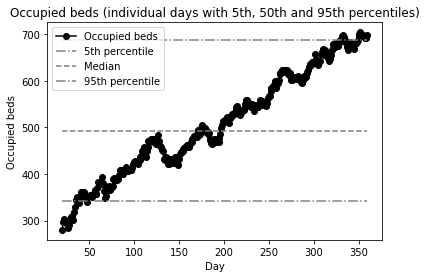

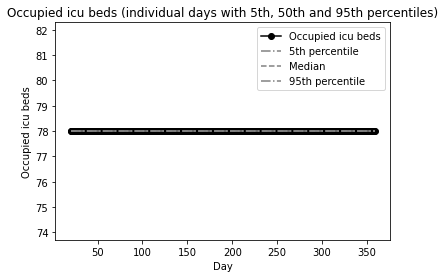

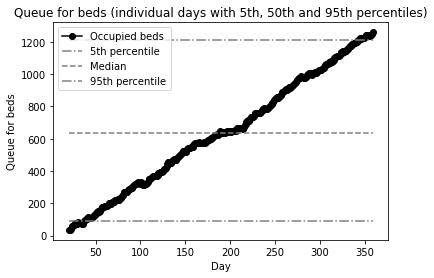

In [131]:
model.hospital.chart()